<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;">Stroke Prediction</h1>

In [1]:
import pandas as pd;
import numpy as np;
import tensorflow as tf;
import matplotlib;
import matplotlib.pyplot as plt;
import seaborn as sns;
from sklearn.linear_model import LogisticRegression;
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split;
from imblearn.over_sampling import SMOTE;

DATASET_FILE_PATH = "healthcare-dataset-stroke-data.csv";
GREEN = "\033[32m";
WHITE = "\033[0m";
RED = "\033[31m";

tf.random.set_seed(42);

matplotlib.rcParams['figure.figsize'] = [24, 6];

<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;">Function definitions</h1>

In [2]:
def Sep() -> None:
    print("\n");

In [3]:
def CountValues(col, value) -> int:
    count = 0;
    for val in col:
        if val == value:
            count += 1;
    return count;

In [4]:
# Prints the data that we wanna know about our dataset
def get_info(data : pd.DataFrame) -> None:
    
    # Labels
    print(GREEN , "Label Names : ", WHITE);
    for col in data:
        print(col, end = ", ");
    Sep();

    # Shape
    print(GREEN, "Datatypes : ", WHITE);
    display(data.dtypes);
    Sep();

    # Data
    print(GREEN, "Data : ", WHITE);
    display(data.head());

    # Description
    print(GREEN, "Data Description: ", WHITE);
    display(data.describe());
    Sep();

    # Number of unique values
    print(GREEN, "Unique Values: ", WHITE);
    for col in data:
        print(col,": ", data[col].nunique());
    Sep();
        
    # Find Null Values
    print(GREEN, "Null Values: ", WHITE);
    display(data.isnull().sum()); 
    Sep();

    # Find 0 values
    print(GREEN, "0 Value Count : ", WHITE);
    for col in data:
        val = CountValues(data[col],0);
        if val > 0:
            print(col , ":",  RED , val , WHITE);
        else:
            print(col, ":", val);

In [5]:
def plot_numerical(data : pd.DataFrame) -> None:
    for col in data:
        if(data[col].dtype == "object"):
            continue;
        
        print(GREEN, col, " :", WHITE);

        # Plot numerical
        f, axes = plt.subplots(1, 3, figsize=(20, 5));
        sns.boxplot(data[col], ax = axes[0], orient = "h");
        sns.histplot(data[col], ax = axes[1]);
        sns.violinplot(data[col], ax = axes[2], orient = "h");
        plt.show();

In [6]:
# Plots the categorical data
def plot_categorical(data : pd.DataFrame) -> None:
    for col in data:
        if(data[col].dtype == "object"):
            continue;

        print(GREEN, col, " :", WHITE);

        # Plot categorical
        sns.catplot(data = data, y = col, kind="count", height=5, aspect=3);
        plt.show();

In [7]:
def remove_outliers(data : pd.DataFrame,columns : list) -> pd.DataFrame:
    for col in columns:
        Q1 = data[columns].quantile(0.25)
        Q3 = data[columns].quantile(0.75)
        IQR = Q3 - Q1
        tempdf = data[~((data[columns] < (Q1 - 1.5 * IQR)) |(data[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return tempdf;

In [8]:
def minmax(data : pd.DataFrame) -> pd.DataFrame:
    min = data.min();
    max = data.max();
    return (data - min) / (max - min);

<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;">Data Preparations</h1>

<p style="color:lightgreen;">Importing dataset</p>

In [9]:
data = pd.read_csv(DATASET_FILE_PATH);

<p style="color:lightgreen;"> Lets take a look at our data </p>

In [10]:
get_info(data);

 Label Names :  
id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke, 

 Datatypes :  


id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object



 Data :  


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


 Data Description:  


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000




 Unique Values:  
id :  5110
gender :  3
age :  104
hypertension :  2
heart_disease :  2
ever_married :  2
work_type :  5
Residence_type :  2
avg_glucose_level :  3979
bmi :  418
smoking_status :  4
stroke :  2


 Null Values:  


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64



 0 Value Count :  
id : 0
gender : 0
age : 0
hypertension :  4612 
heart_disease :  4834 
ever_married : 0
work_type : 0
Residence_type : 0
avg_glucose_level : 0
bmi : 0
smoking_status : 0
stroke :  4861 


<p style="color:lightgreen;"> Looking at the dataset, we can do some basic cleaning and encoding of the values </p>

In [11]:
# Dropping the id column since we don't need it
data = data.drop("id", axis = 1);

In [12]:
# Dropping all null values. Since the number of null values is <5%, we can afford to drop them.
data = data.dropna();

In [13]:
# Encoding gender
data = data[data.gender != "Other"]; # Removing other values
data["is_male"] = np.where(data["gender"] == "Male", 1, 0); # encoding male = 1, female = 0;
data.drop("gender", axis = 1, inplace = True);

In [14]:
# Encoding ever_married
data["ever_married"] = np.where(data["ever_married"] == "Yes", 1, 0);

In [15]:
# Encoding residence type
data["is_urban"] = np.where(data["Residence_type"] == "Urban", 1, 0); # encoding urban = 1, rural = 0;
data.drop("Residence_type", axis = 1, inplace = True);

In [16]:
# Encoding smoking status
data = data[data.smoking_status != "Unknown"]; # Removing unknown values
for row in data["smoking_status"]:
    if row == "never smoked":
        data["smoking_status"] = data["smoking_status"].replace(row, 0);
    elif row == "formerly smoked":
        data["smoking_status"] = data["smoking_status"].replace(row, 1);
    elif row == "smokes":
        data["smoking_status"] = data["smoking_status"].replace(row, 2);

In [17]:
# Encoding work type
for row in data["work_type"]:
    if row == "children":
        data["work_type"] = data["work_type"].replace(row, 0);
    elif row == "Never_worked":
        data["work_type"] = data["work_type"].replace(row, 1);
    elif row == "Private":
        data["work_type"] = data["work_type"].replace(row, 2);
    elif row == "Self-employed":
        data["work_type"] = data["work_type"].replace(row, 3);
    elif row == "Govt_job":
        data["work_type"] = data["work_type"].replace(row, 4);

In [18]:
# Casting age to int from float
data["age"] = data["age"].astype(int);

In [19]:
get_info(data);

 Label Names :  
age, hypertension, heart_disease, ever_married, work_type, avg_glucose_level, bmi, smoking_status, stroke, is_male, is_urban, 

 Datatypes :  


age                    int32
hypertension           int64
heart_disease          int64
ever_married           int32
work_type              int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
is_male                int32
is_urban               int32
dtype: object



 Data :  


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_male,is_urban
0,67,0,1,1,2,228.69,36.6,1,1,1,1
2,80,0,1,1,2,105.92,32.5,0,1,1,0
3,49,0,0,1,2,171.23,34.4,2,1,0,1
4,79,1,0,1,3,174.12,24.0,0,1,0,0
5,81,0,0,1,2,186.21,29.0,1,1,1,1


 Data Description:  


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_male,is_urban
count,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000
mean,48.652555,0.119124,0.060146,0.758832,2.440000,108.311670,30.292350,0.674453,0.052555,0.390949,0.509489
std,18.850018,0.323982,0.237792,0.427854,0.821001,47.706754,7.295778,0.806301,0.223175,0.488034,0.499983
min,10.000000,0.000000,0.000000,0.000000,0.000000,55.120000,11.500000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,0.000000,0.000000,1.000000,2.000000,77.230000,25.300000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,0.000000,0.000000,1.000000,2.000000,92.350000,29.100000,0.000000,0.000000,0.000000,1.000000
75%,63.000000,0.000000,0.000000,1.000000,3.000000,116.200000,34.100000,1.000000,0.000000,1.000000,1.000000
max,82.000000,1.000000,1.000000,1.000000,4.000000,271.740000,92.000000,2.000000,1.000000,1.000000,1.000000




 Unique Values:  
age :  73
hypertension :  2
heart_disease :  2
ever_married :  2
work_type :  5
avg_glucose_level :  2903
bmi :  370
smoking_status :  3
stroke :  2
is_male :  2
is_urban :  2


 Null Values:  


age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
is_male              0
is_urban             0
dtype: int64



 0 Value Count :  
age : 0
hypertension :  3017 
heart_disease :  3219 
ever_married :  826 
work_type :  68 
avg_glucose_level : 0
bmi : 0
smoking_status :  1852 
stroke :  3245 
is_male :  2086 
is_urban :  1680 


<p style="color:lightgreen;"> Lets now visualize our data </p>

 age  : 


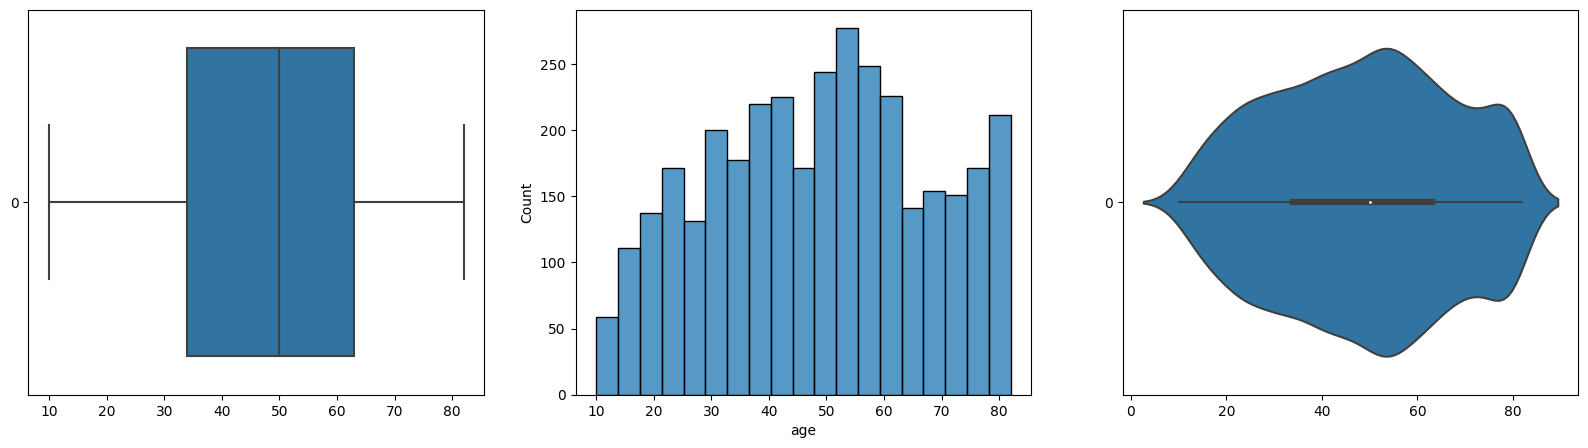

 avg_glucose_level  : 


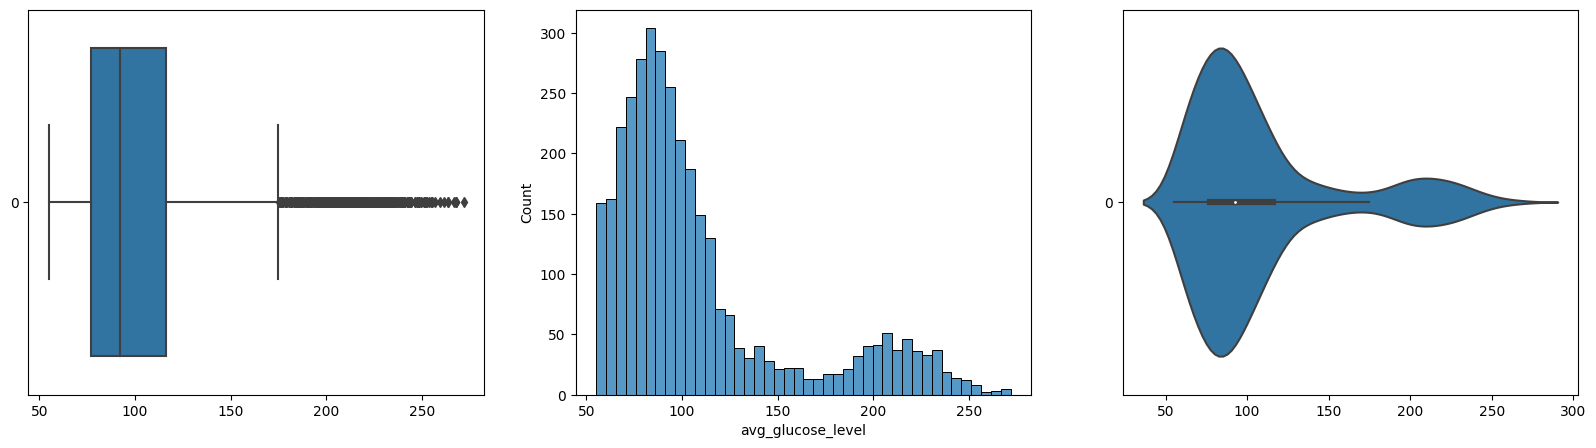

 bmi  : 


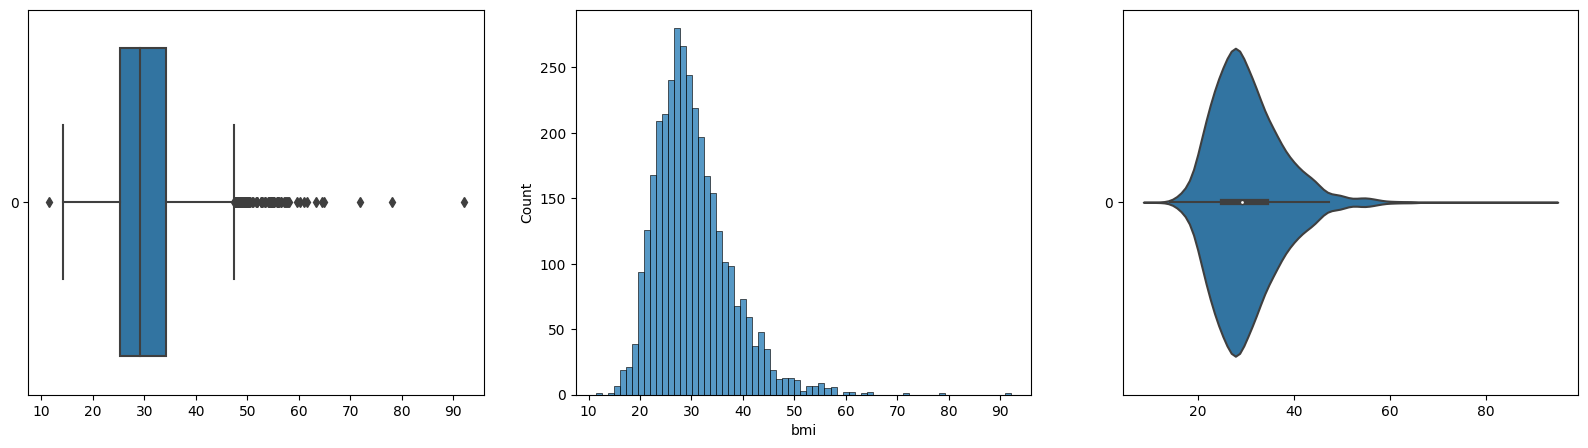

In [20]:
numerical = data[["age", "avg_glucose_level", "bmi"]];
plot_numerical(numerical);

<p style="color:lightgreen;"> We can see both ave_glucose_level and bmi have values outside the boxplot. We can say that even though there are values outside the boxplot for ave_glucose_level those aren't outliers because there are a lot of values there. bmi on the other hand has outliers and we need to remove those for better prediction outcomes </p>

 bmi  : 


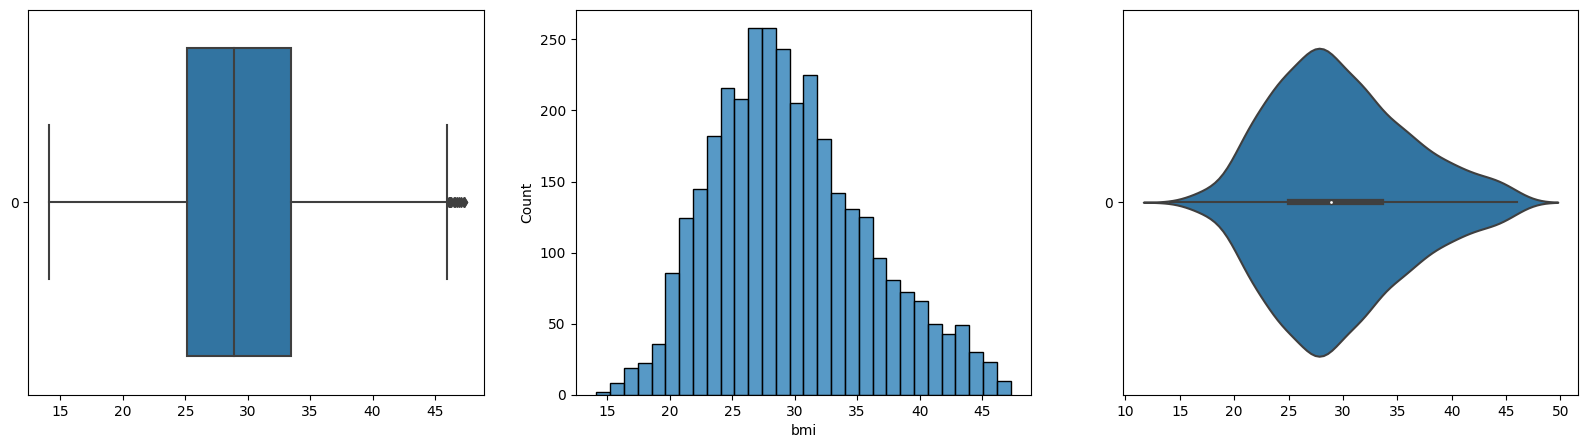

In [21]:
data = remove_outliers(data = data, columns = ["bmi"]);
plot_numerical(data[["bmi"]]);

 is_male  : 


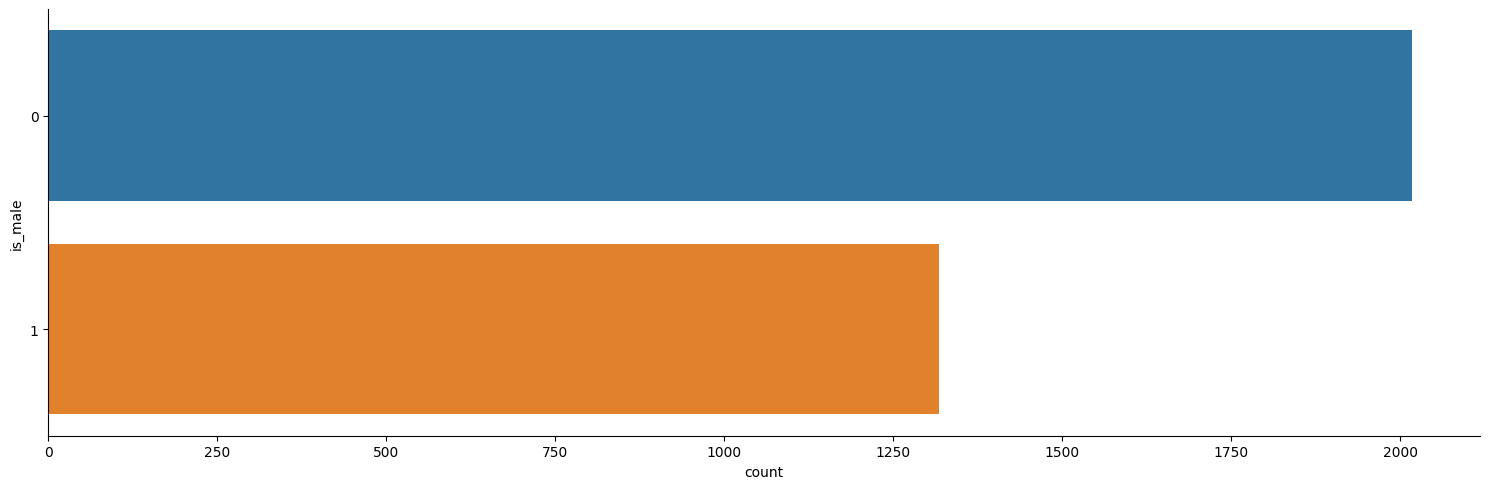

 hypertension  : 


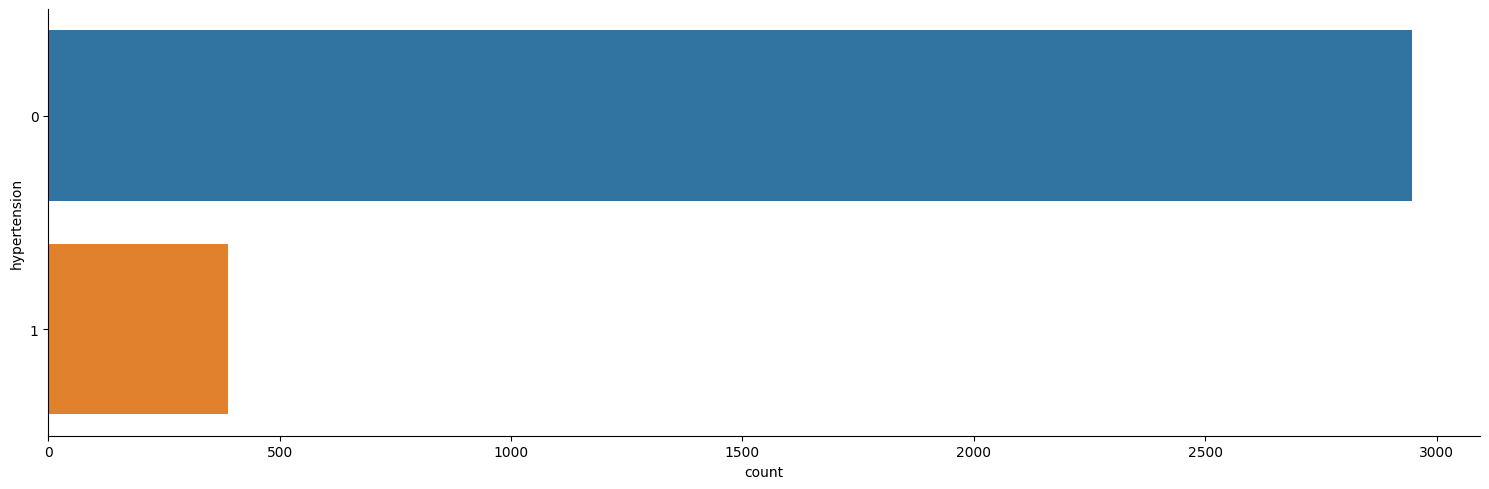

 heart_disease  : 


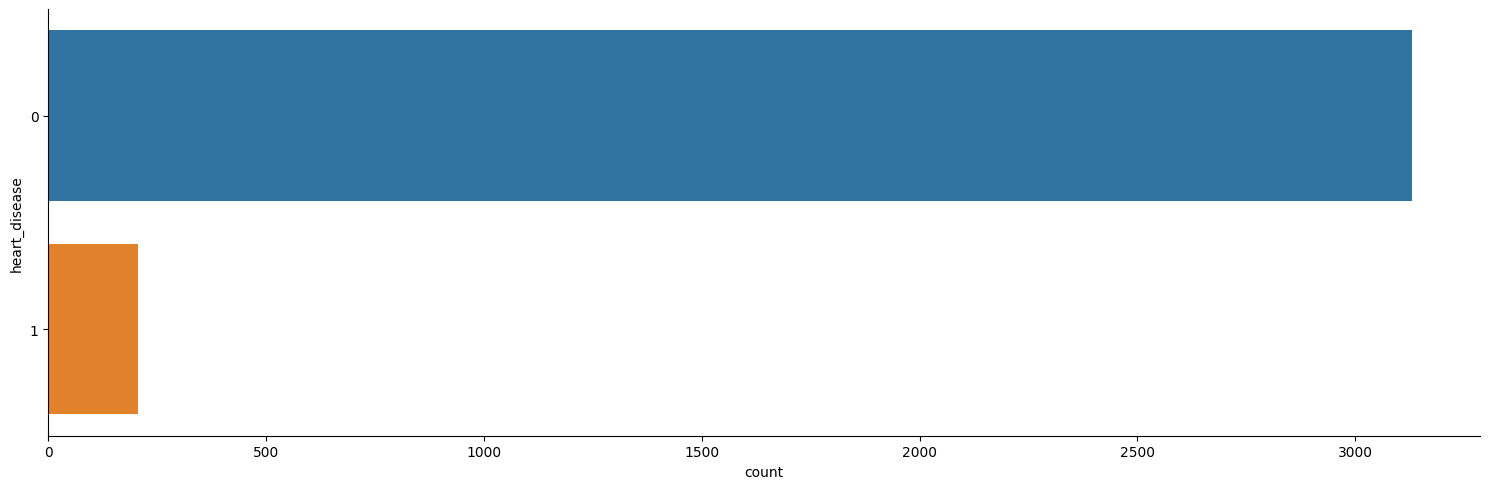

 work_type  : 


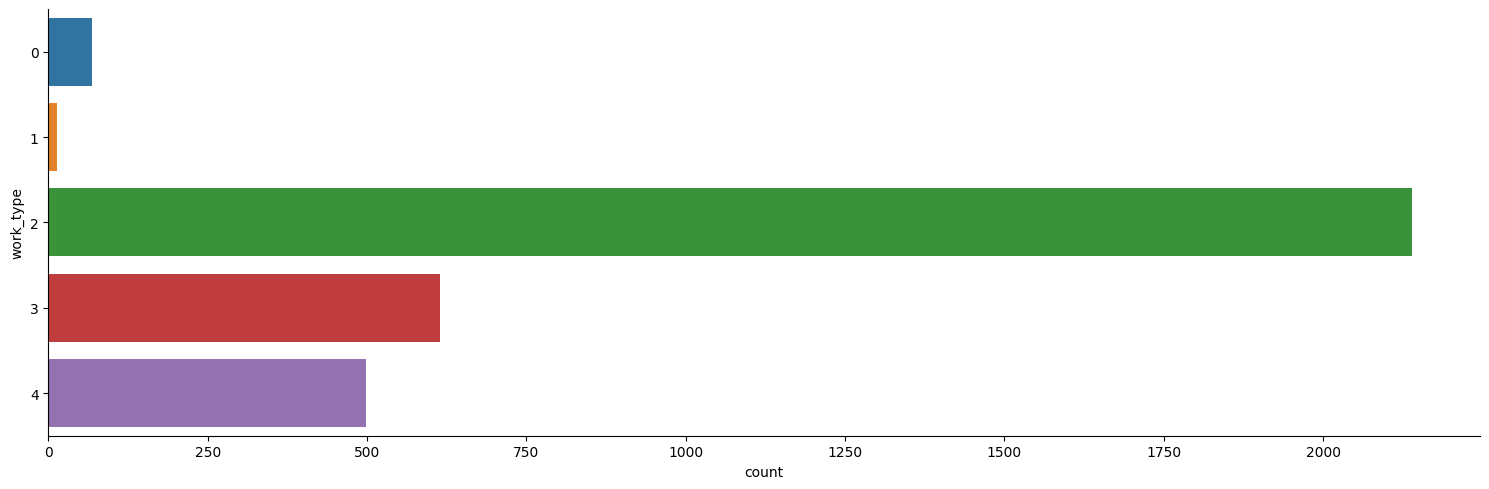

 ever_married  : 


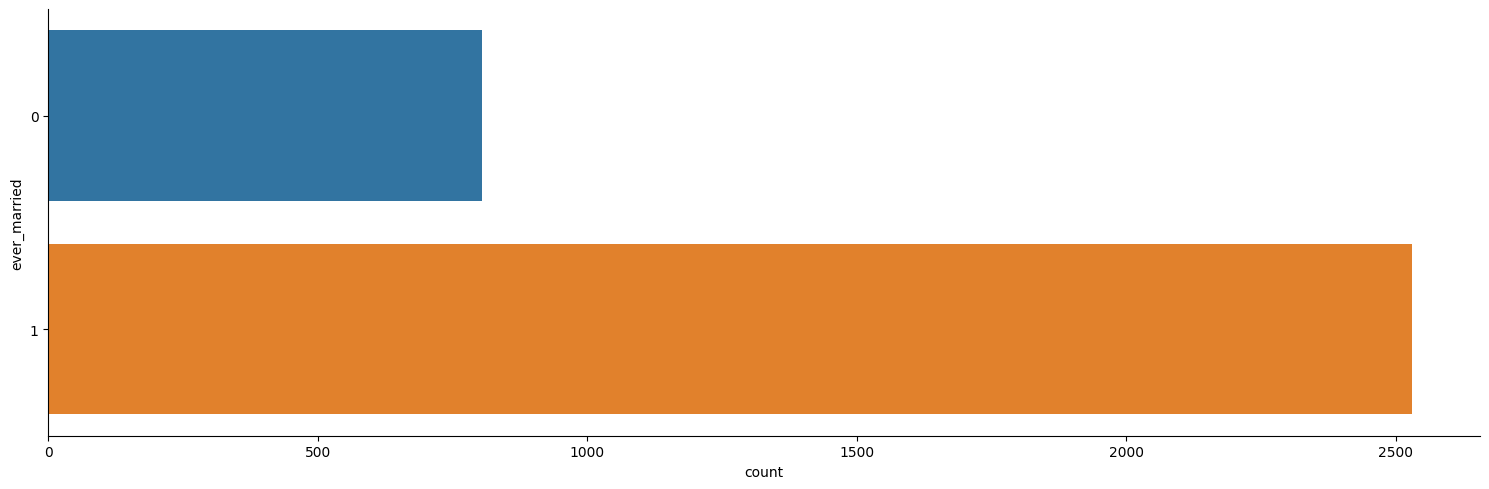

 is_urban  : 


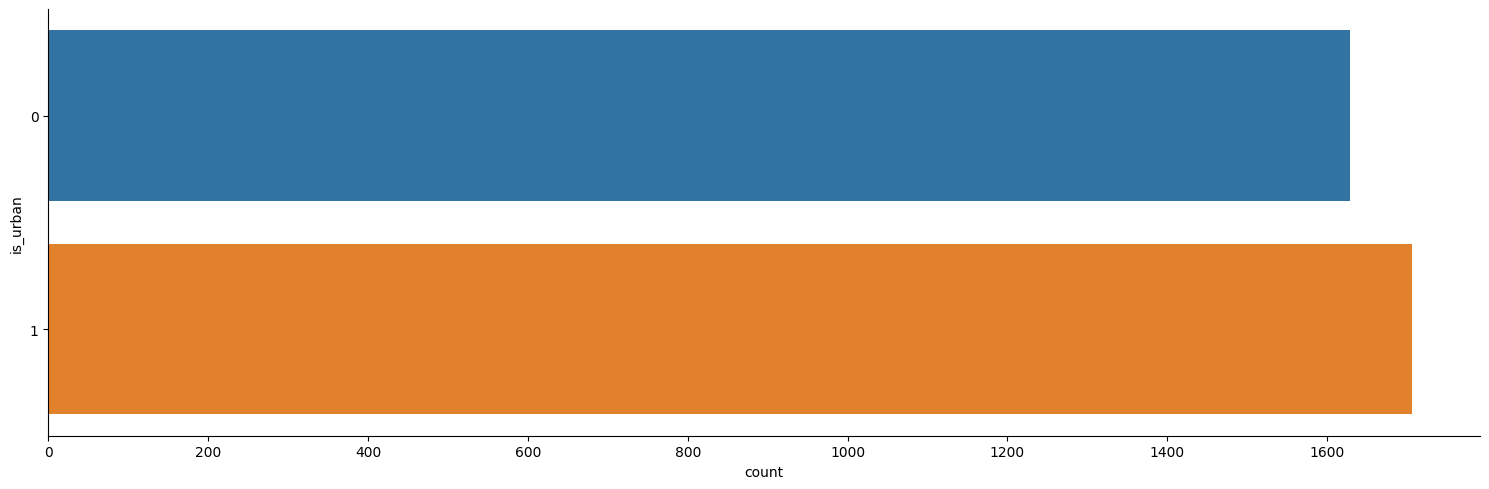

 smoking_status  : 


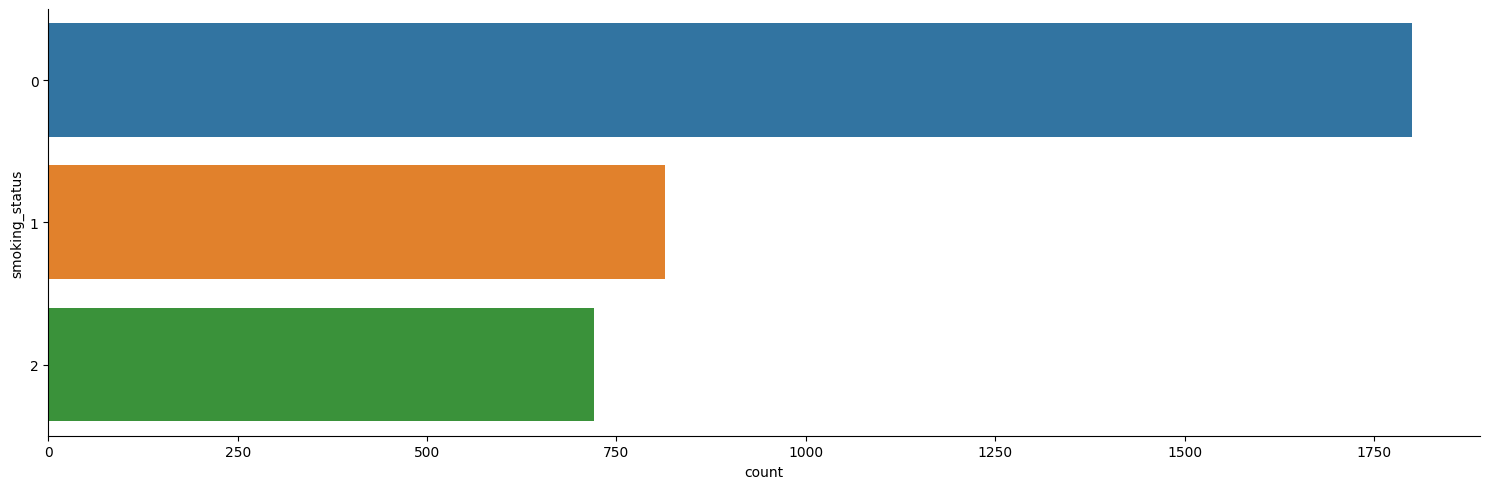

 stroke  : 


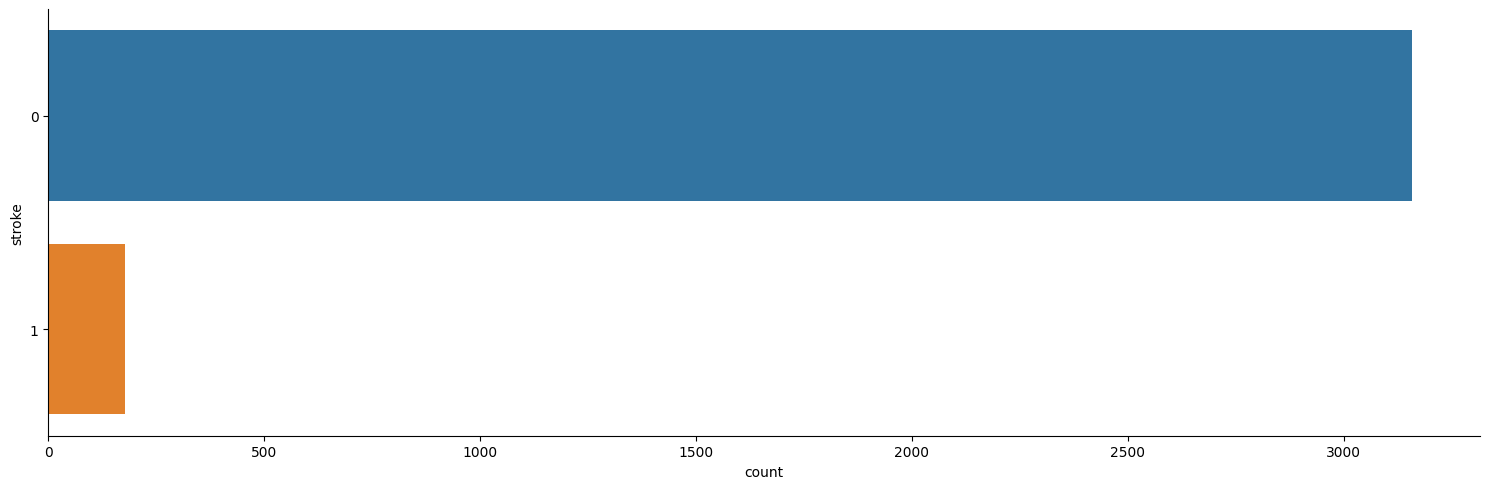

In [22]:
catergorical = data[["is_male","hypertension", "heart_disease", "work_type", "ever_married", "is_urban", "smoking_status", "stroke"]];
plot_categorical(catergorical);

 stroke  : 


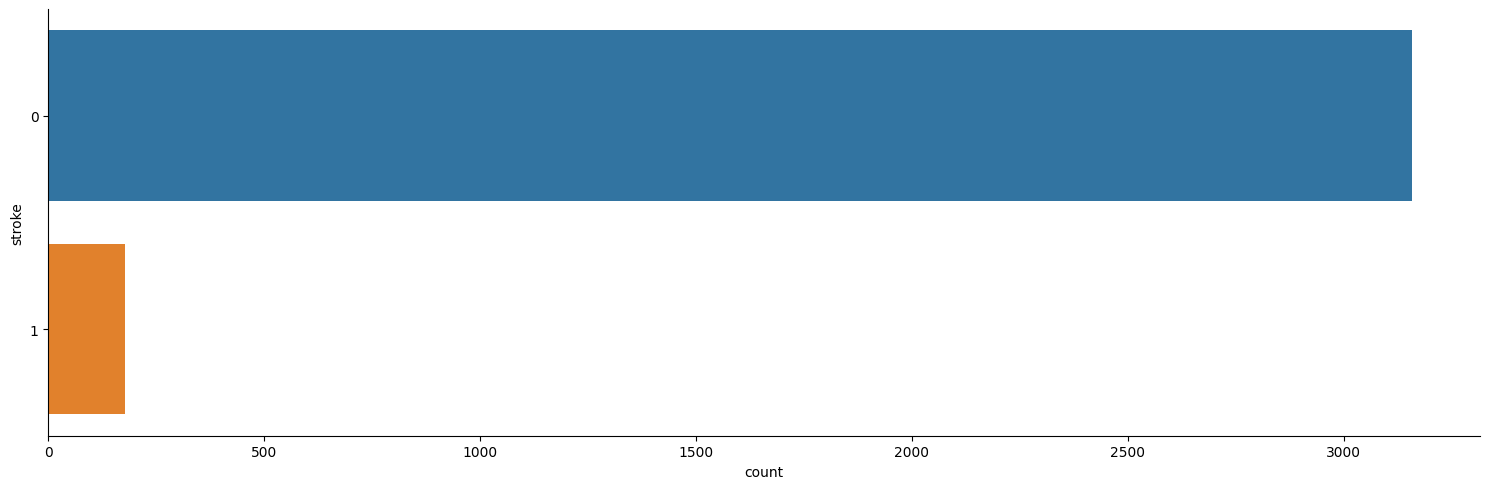

In [23]:
plot_categorical(data[["stroke"]]);

<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;"> Exploratory Data Analysis</h1>

<p style="color:lightgreen;"> Now that our data is a little cleaner, its time to see which ones have the highest <span style="color:red;"> correlation </span>.</p>

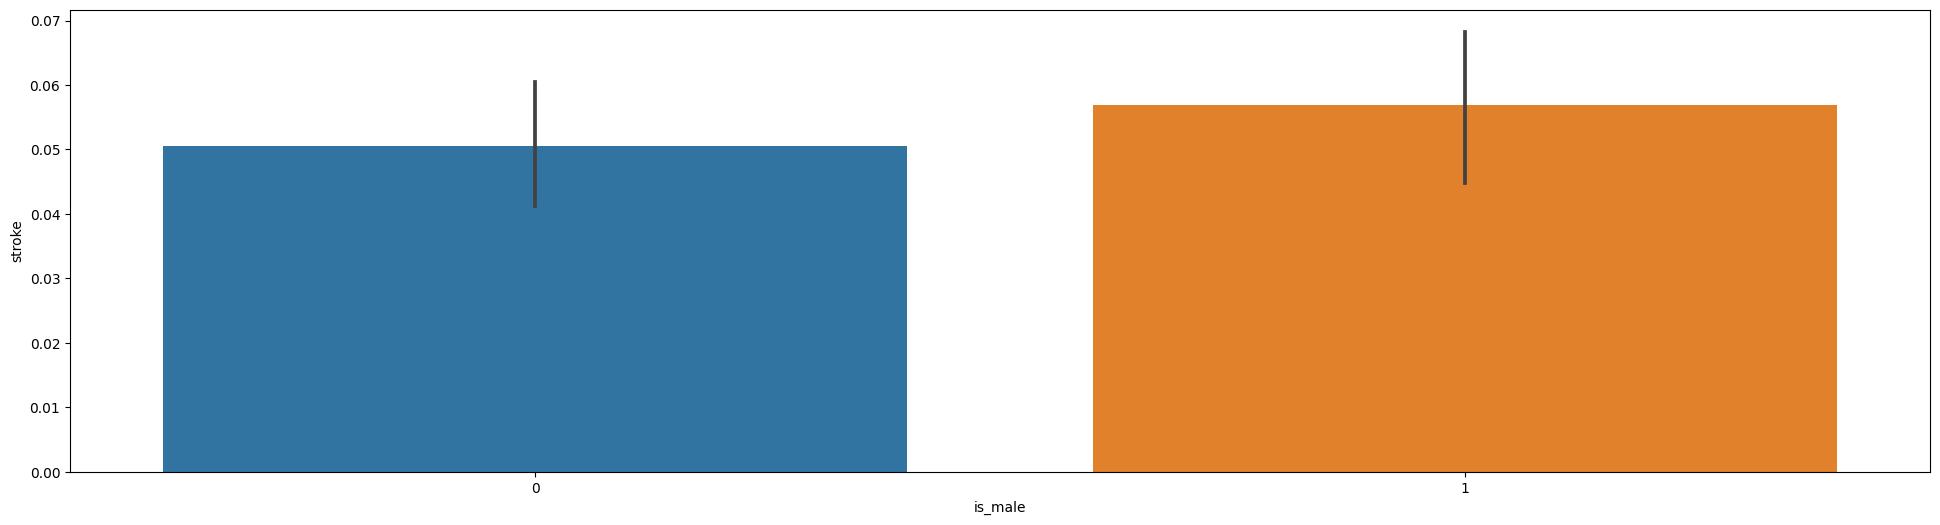

In [24]:
sns.barplot(data = data, x = "is_male", y = "stroke");

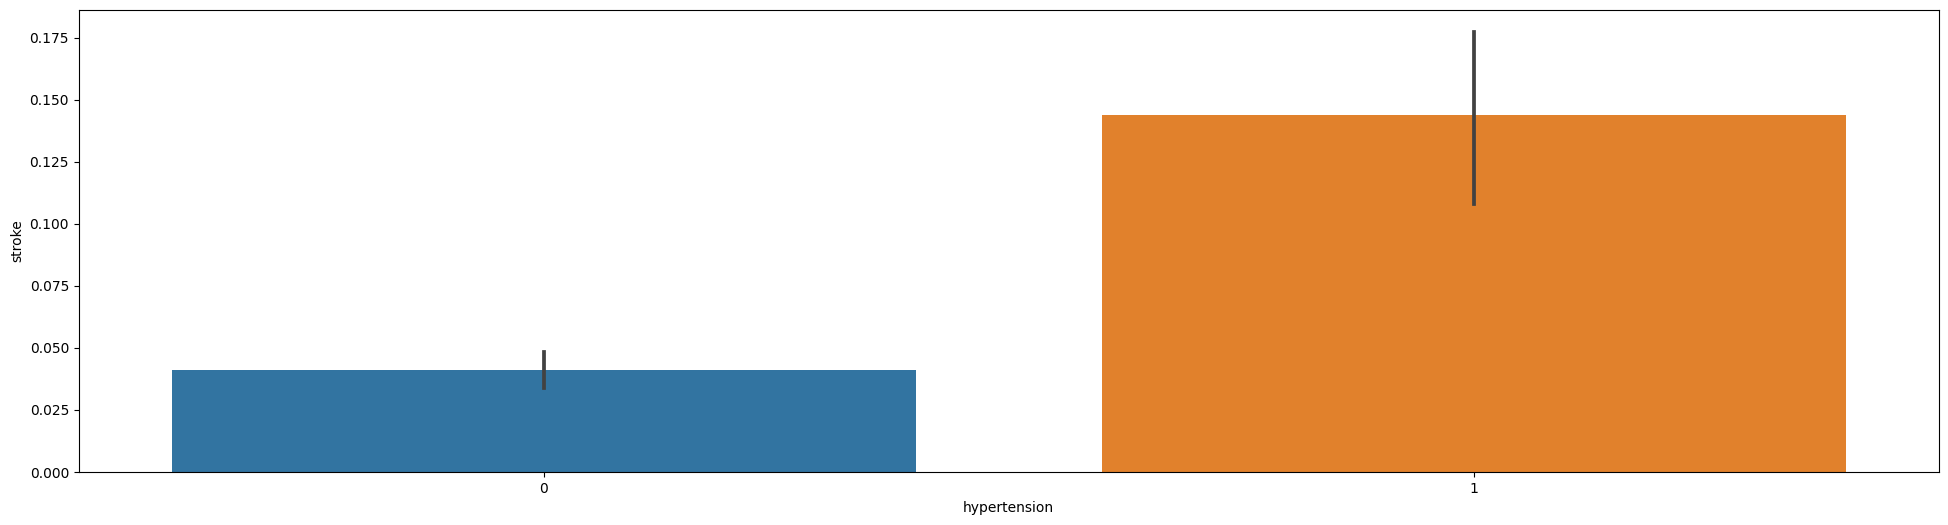

In [25]:
sns.barplot(data = data, x = "hypertension", y = "stroke");

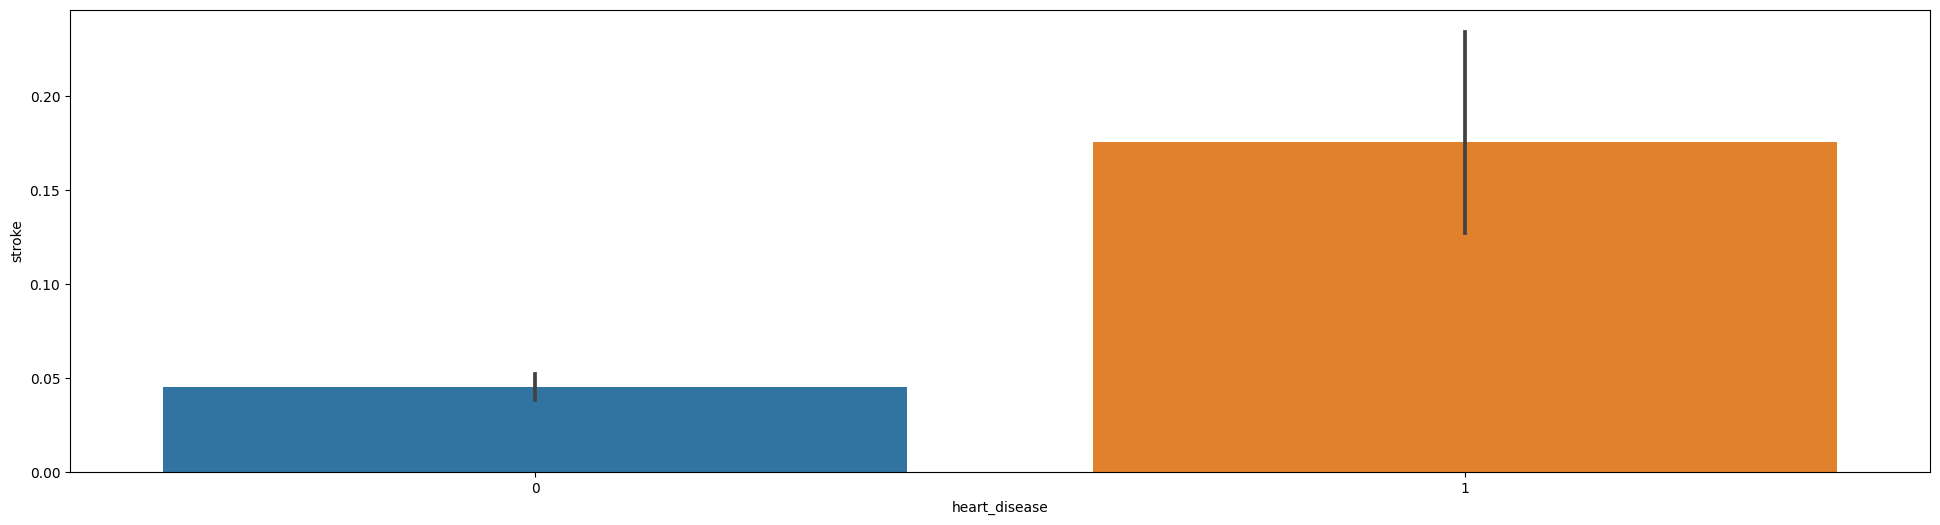

In [26]:
sns.barplot(data = data, x = "heart_disease", y = "stroke");

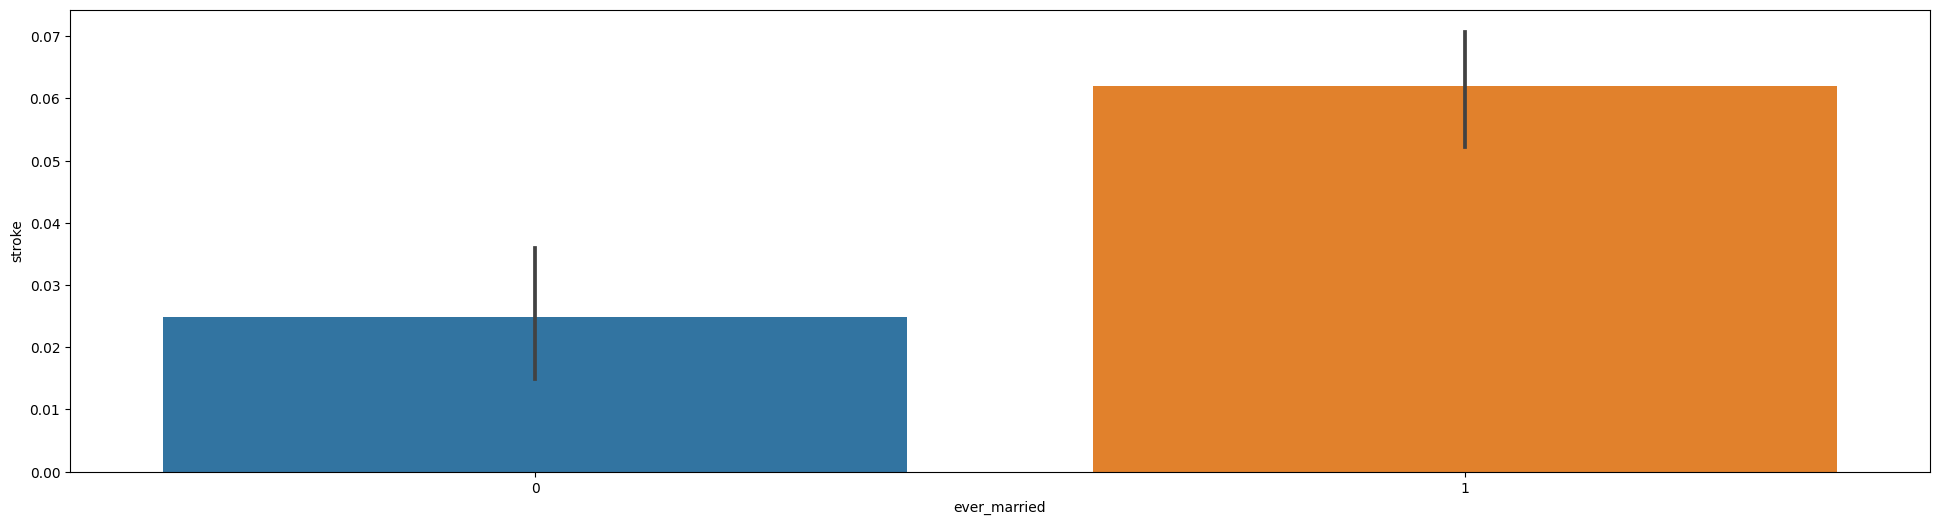

In [27]:
sns.barplot(data = data, x = "ever_married", y = "stroke");

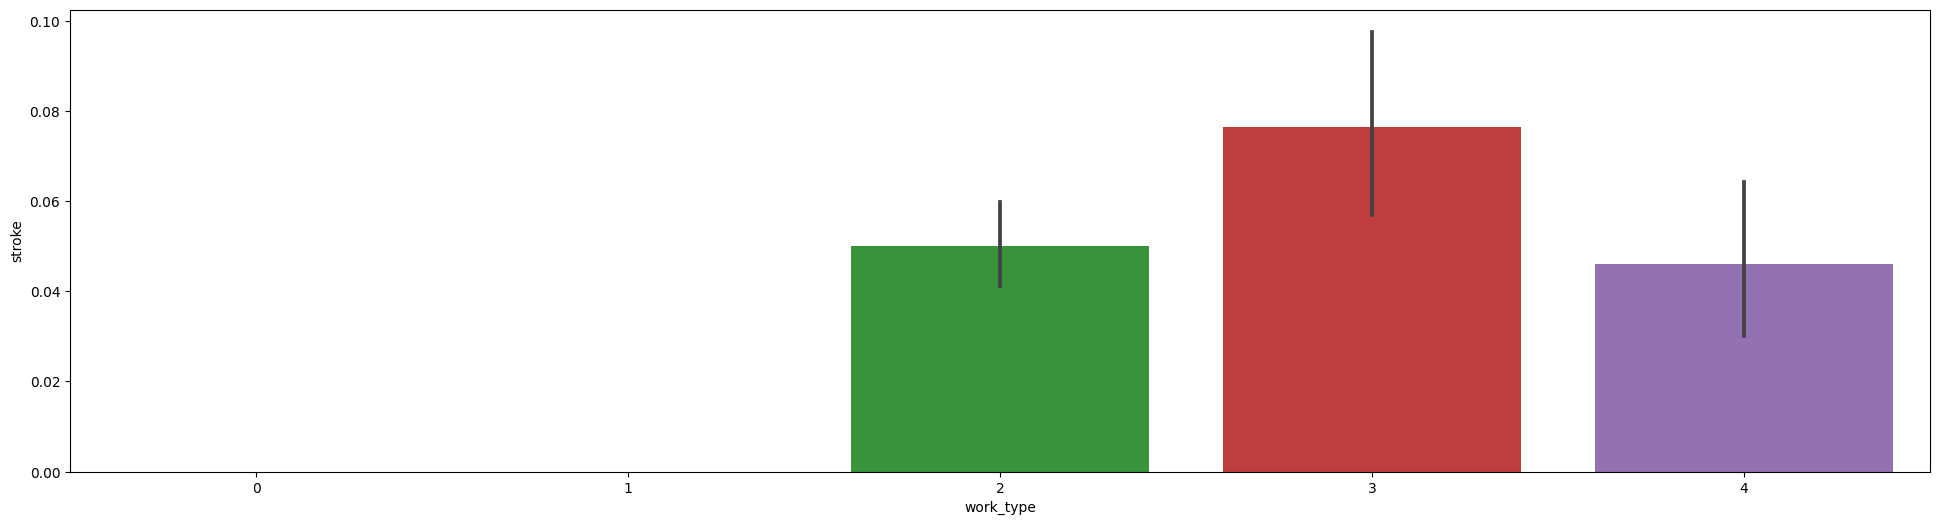

In [28]:
sns.barplot(data = data, x = "work_type", y = "stroke");

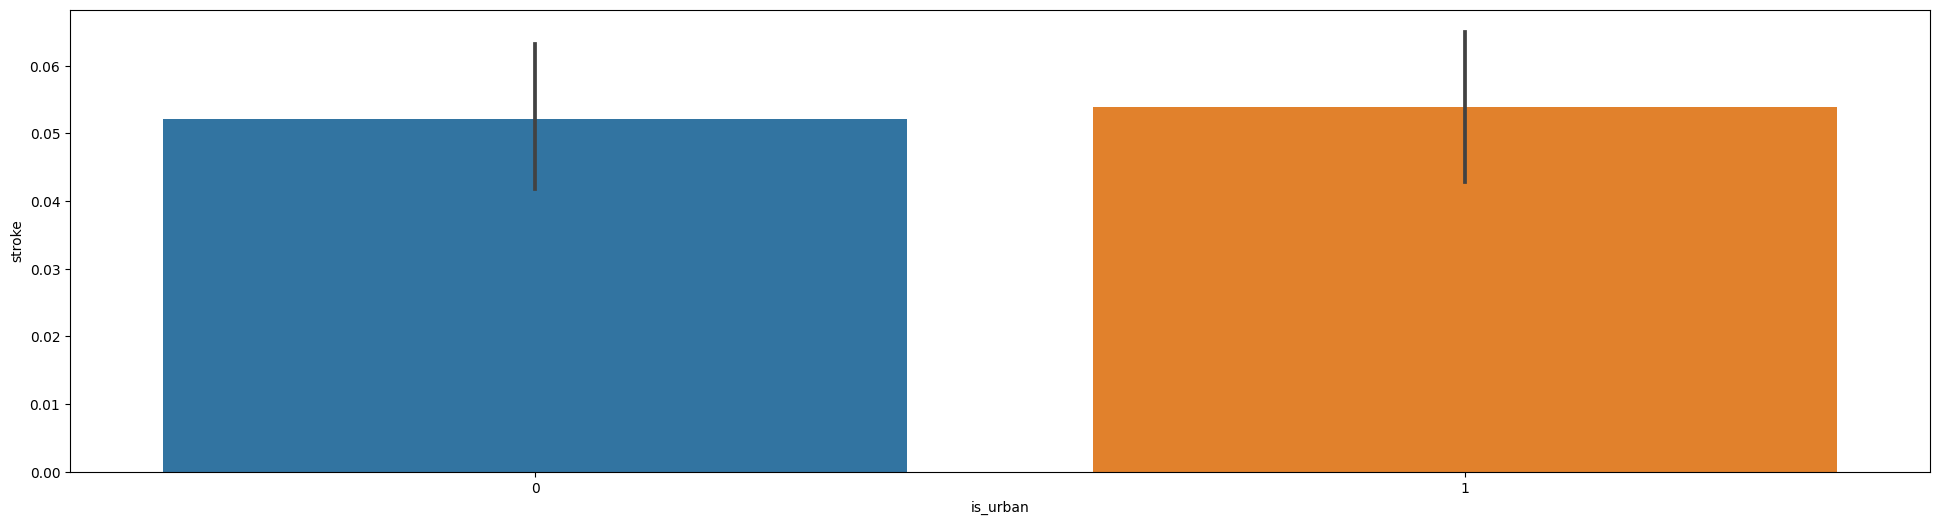

In [29]:
sns.barplot(data = data, x = "is_urban", y = "stroke");

<p style="color:lightgreen;"> Looking at the plots for our categorical values, we can see that <span style="color:red;"> hypertension </span> , <span style="color:red;">heart_disease</span> and <span style="color:red;">ever_married </span> have the most correlation to stroke.

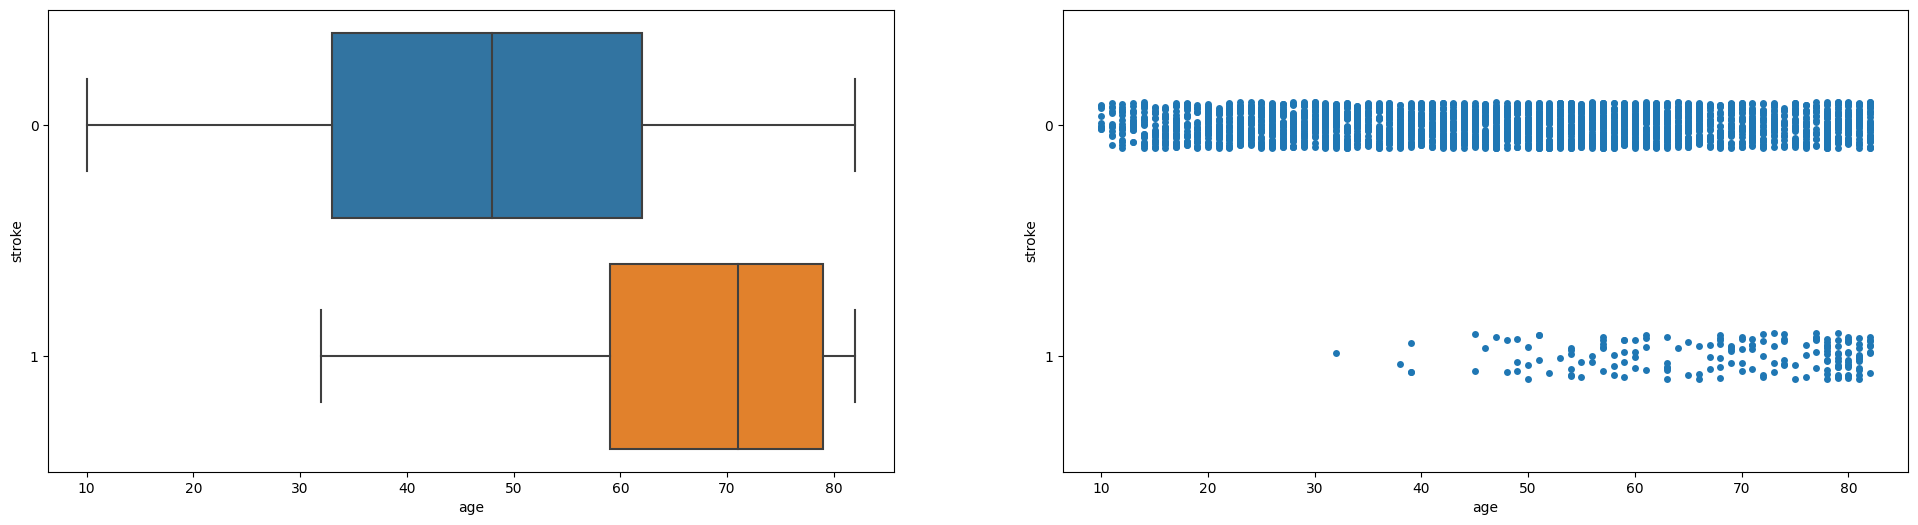

In [30]:
# Plottting age against stroke
f, axes = plt.subplots(1,2, figsize=(24,6));
sns.boxplot(data= data, x="age", y="stroke", orient="h", ax = axes[0]);
sns.stripplot(data= data, x="age", y="stroke", orient="h", ax= axes[1]);
plt.show();

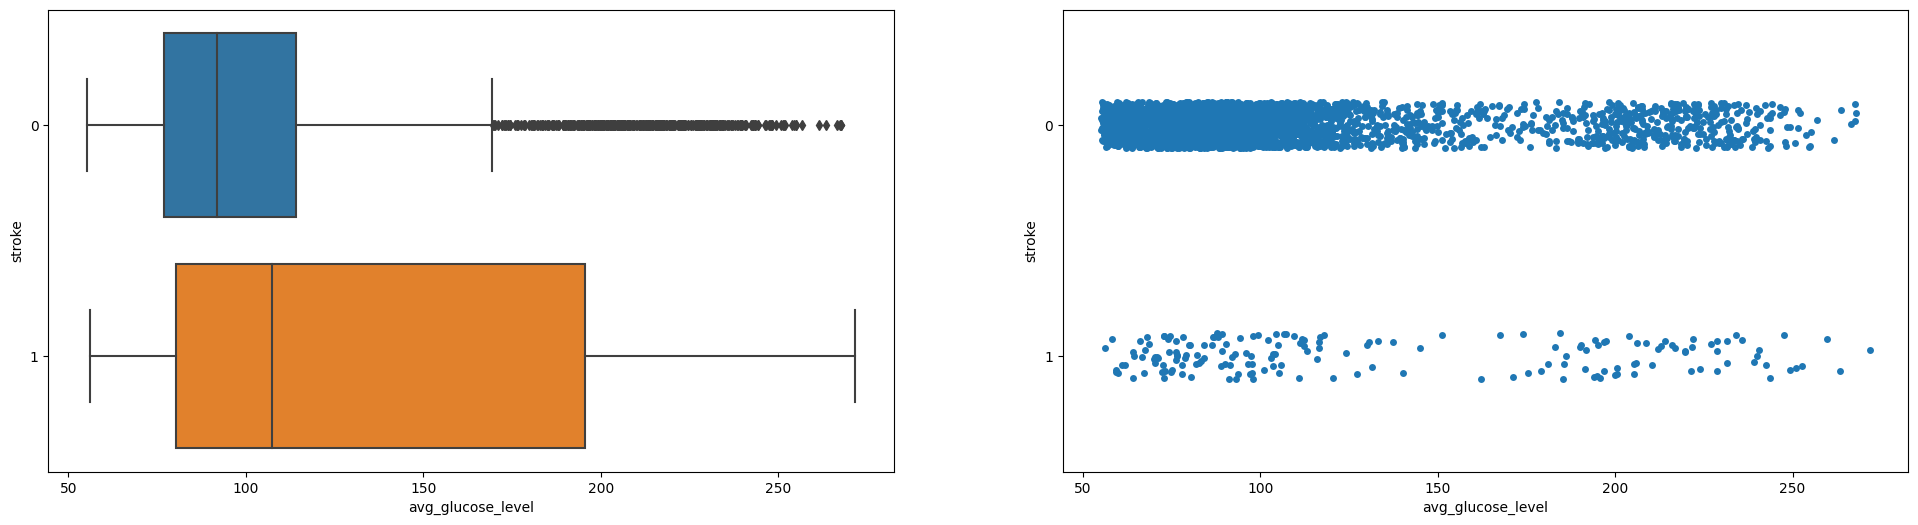

In [31]:
# Plottting avg_glucose_level against stroke
f, axes = plt.subplots(1,2, figsize=(24,6));
sns.boxplot(data = data, x="avg_glucose_level", y="stroke", orient="h", ax = axes[0]);
sns.stripplot(data = data, x="avg_glucose_level", y="stroke", orient="h", ax= axes[1]);
plt.show();

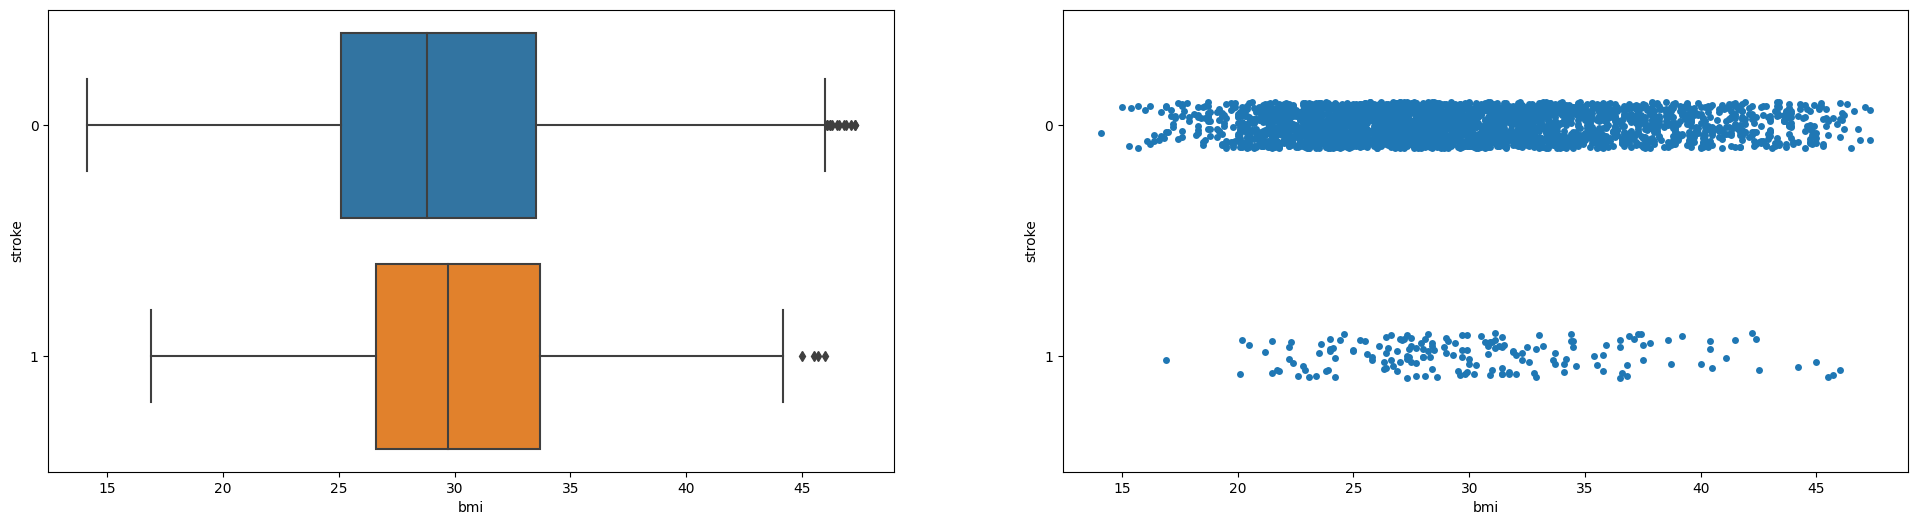

In [32]:
# Plotting bmi against stroke
f, axes = plt.subplots(1,2, figsize=(24,6));
sns.boxplot(data= data, x="bmi", y="stroke", orient="h", ax = axes[0]);
sns.stripplot(data= data, x="bmi", y="stroke", orient="h", ax= axes[1]);
plt.show();

<p style="color:lightgreen;"> Looking at the plots for our numerical values, we can see that <span style="color:red;">age</span> is the the most important feature.

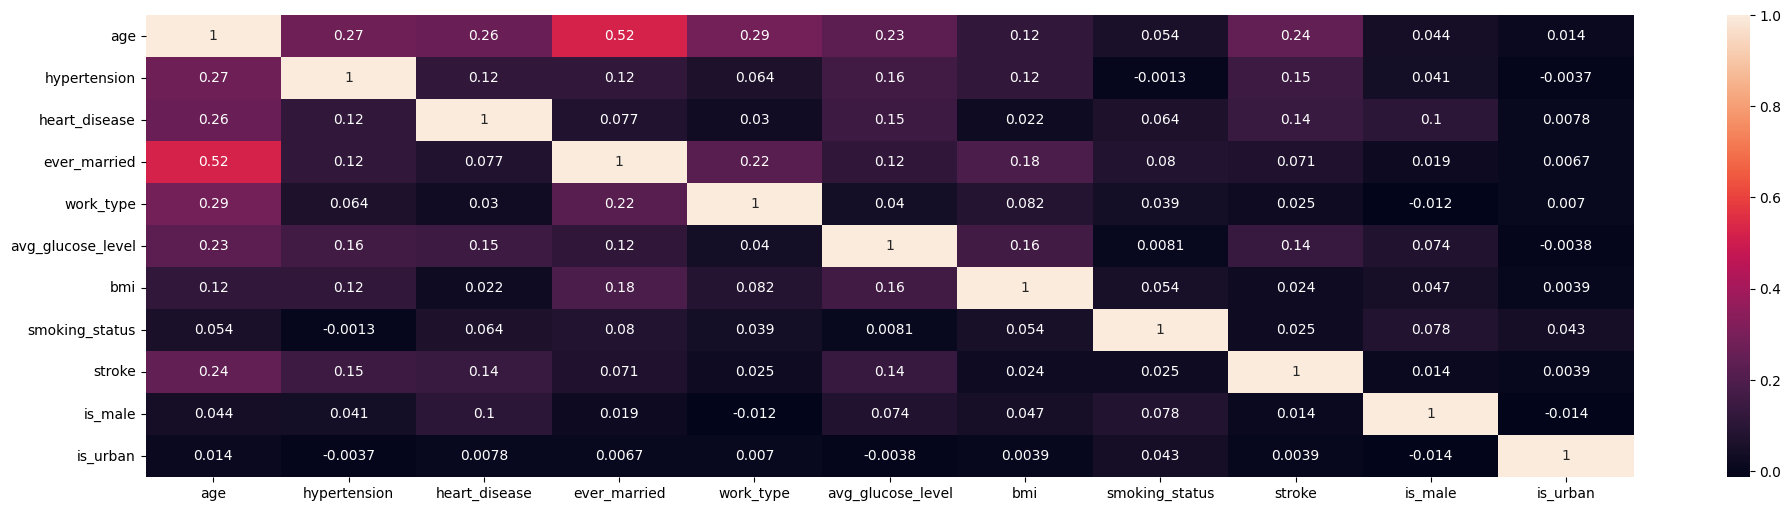

In [33]:
sns.heatmap(data.corr(), annot = True);

<p style="color:lightgreen;"> Looking at the correlation matrix, we can observe the same things. </p>

<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;"> Model creation (Logistic Regreesion) and data scaling</h1>

<p style="color:lightgreen;"> Before we train our model, we are going to have to normalize and split our dataset. </p>

In [34]:
display(data);

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_male,is_urban
0,67,0,1,1,2,228.69,36.6,1,1,1,1
2,80,0,1,1,2,105.92,32.5,0,1,1,0
3,49,0,0,1,2,171.23,34.4,2,1,0,1
4,79,1,0,1,3,174.12,24.0,0,1,0,0
5,81,0,0,1,2,186.21,29.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5100,82,1,0,1,3,71.97,28.3,0,0,1,0
5102,57,0,0,1,2,77.93,21.7,0,0,0,0
5106,81,0,0,1,3,125.20,40.0,0,0,0,1
5107,35,0,0,1,3,82.99,30.6,0,0,0,0


In [35]:
data["age"] = minmax(data["age"]);
data["avg_glucose_level"] = minmax(data["avg_glucose_level"]);
data["bmi"] = minmax(data["bmi"]);
display(data);

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_male,is_urban
0,0.791667,0,1,1,2,0.801265,0.677711,1,1,1,1
2,0.972222,0,1,1,2,0.234512,0.554217,0,1,1,0
3,0.541667,0,0,1,2,0.536008,0.611446,2,1,0,1
4,0.958333,1,0,1,3,0.549349,0.298193,0,1,0,0
5,0.986111,0,0,1,2,0.605161,0.448795,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5100,1.000000,1,0,1,3,0.077786,0.427711,0,0,1,0
5102,0.652778,0,0,1,2,0.105300,0.228916,0,0,0,0
5106,0.986111,0,0,1,3,0.323516,0.780120,0,0,0,1
5107,0.347222,0,0,1,3,0.128658,0.496988,0,0,0,0


In [36]:
x_train, y_train, x_test, y_test = train_test_split(data.drop("stroke", axis = 1), data["stroke"], test_size = 0.2, random_state = 42);
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape);

(2668, 10) (667, 10) (2668,) (667,)


<p style="color:lightgreen;"> Time to create and fit the model. </p>

(2668, 10) (667, 10) (2668,) (667,)
Accuracy:  0.9370314842578711


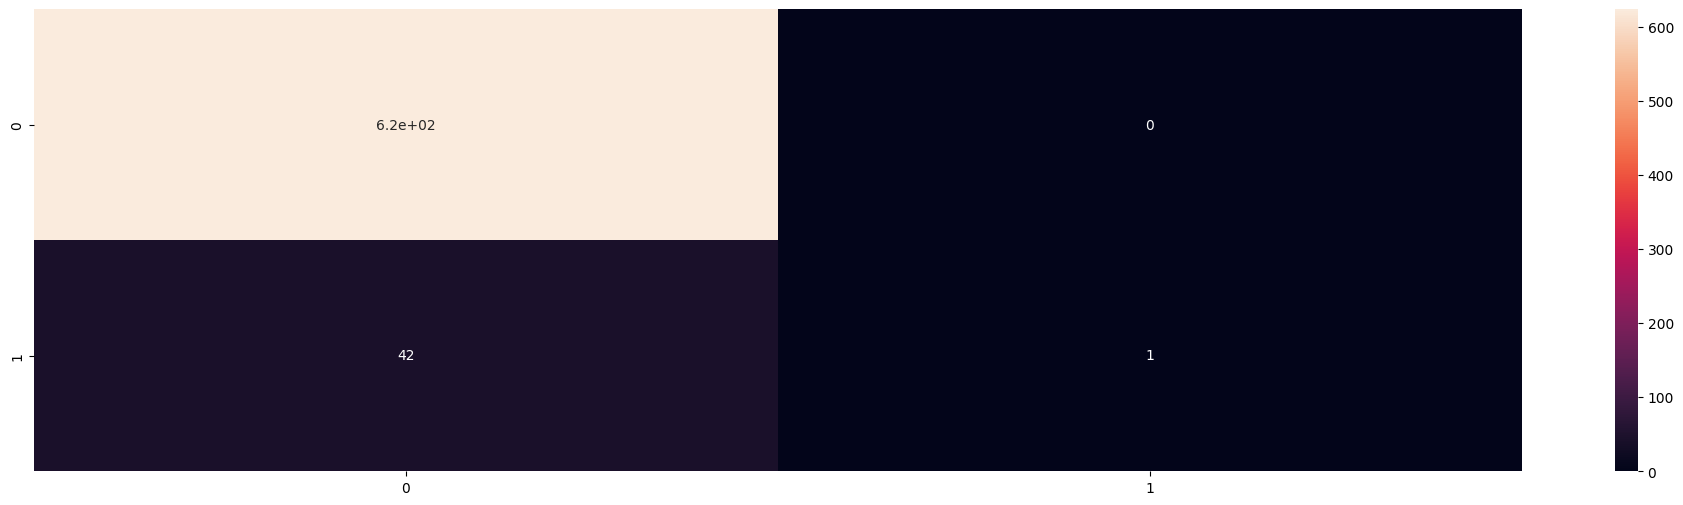

In [37]:

x_train, y_train, x_test, y_test = train_test_split(data.drop("stroke", axis = 1), data["stroke"], test_size = 0.2, random_state = 42);
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape);
logreg = LogisticRegression();
logreg.fit(x_train, x_test);
prediction = logreg.predict(y_train);
confusion = confusion_matrix(y_test, prediction);

print("Accuracy: ", accuracy_score(y_test, prediction));
sns.heatmap(confusion, annot = True);

<p style="color:lightgreen;"> Wow! Our model looks like its performing well, it is a bit useless though because of our <span style="color:red;"> imbalanced dataset</span>, we are going to use <span style="color:red;">SMOTE</span> to allow our model to predict more <span style="color:red;">True positives</span>.</p>

<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;">Balancing of dataset</h1>

In [38]:
display(data);
data_x, data_y = SMOTE().fit_resample(data.drop("stroke", axis = 1), data["stroke"]);
data = pd.concat([data_x, data_y], axis = 1);
display(data);

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_male,is_urban
0,0.791667,0,1,1,2,0.801265,0.677711,1,1,1,1
2,0.972222,0,1,1,2,0.234512,0.554217,0,1,1,0
3,0.541667,0,0,1,2,0.536008,0.611446,2,1,0,1
4,0.958333,1,0,1,3,0.549349,0.298193,0,1,0,0
5,0.986111,0,0,1,2,0.605161,0.448795,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5100,1.000000,1,0,1,3,0.077786,0.427711,0,0,1,0
5102,0.652778,0,0,1,2,0.105300,0.228916,0,0,0,0
5106,0.986111,0,0,1,3,0.323516,0.780120,0,0,0,1
5107,0.347222,0,0,1,3,0.128658,0.496988,0,0,0,0


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,is_male,is_urban,stroke
0,0.791667,0,1,1,2,0.801265,0.677711,1,1,1,1
1,0.972222,0,1,1,2,0.234512,0.554217,0,1,0,1
2,0.541667,0,0,1,2,0.536008,0.611446,2,0,1,1
3,0.958333,1,0,1,3,0.549349,0.298193,0,0,0,1
4,0.986111,0,0,1,2,0.605161,0.448795,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6311,0.531182,0,0,1,2,0.046791,0.482725,0,0,1,1
6312,0.891889,1,0,1,3,0.634082,0.290030,0,0,1,1
6313,0.952757,0,0,1,2,0.690097,0.494714,0,0,0,1
6314,0.932409,0,0,1,2,0.817021,0.668257,0,0,0,1


<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;">Visualization of balanced dataset</h1>

In [39]:
get_info(data);

 Label Names :  
age, hypertension, heart_disease, ever_married, work_type, avg_glucose_level, bmi, smoking_status, is_male, is_urban, stroke, 

 Datatypes :  


age                  float64
hypertension           int64
heart_disease          int64
ever_married           int32
work_type              int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
is_male                int32
is_urban               int32
stroke                 int64
dtype: object



 Data :  


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,is_male,is_urban,stroke
0,0.791667,0,1,1,2,0.801265,0.677711,1,1,1,1
1,0.972222,0,1,1,2,0.234512,0.554217,0,1,0,1
2,0.541667,0,0,1,2,0.536008,0.611446,2,0,1,1
3,0.958333,1,0,1,3,0.549349,0.298193,0,0,0,1
4,0.986111,0,0,1,2,0.605161,0.448795,1,1,1,1


 Data Description:  


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,is_male,is_urban,stroke
count,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.00000
mean,0.666816,0.173528,0.096738,0.816498,2.428911,0.301084,0.477180,0.673844,0.384262,0.490659,0.50000
std,0.253766,0.378733,0.295625,0.387108,0.738392,0.243975,0.167981,0.776548,0.486459,0.499952,0.50004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.507530,0.000000,0.000000,1.000000,2.000000,0.117070,0.363249,0.000000,0.000000,0.000000,0.00000
50%,0.712896,0.000000,0.000000,1.000000,2.000000,0.207437,0.460164,0.000000,0.000000,0.000000,0.50000
75%,0.885153,0.000000,0.000000,1.000000,3.000000,0.449594,0.579451,1.000000,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.00000




 Unique Values:  
age :  2948
hypertension :  2
heart_disease :  2
ever_married :  2
work_type :  5
avg_glucose_level :  5813
bmi :  3271
smoking_status :  3
is_male :  2
is_urban :  2
stroke :  2


 Null Values:  


age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
avg_glucose_level    0
bmi                  0
smoking_status       0
is_male              0
is_urban             0
stroke               0
dtype: int64



 0 Value Count :  
age :  9 
hypertension :  5220 
heart_disease :  5705 
ever_married :  1159 
work_type :  68 
avg_glucose_level :  1 
bmi :  1 
smoking_status :  3270 
is_male :  3889 
is_urban :  3217 
stroke :  3158 


 age  : 


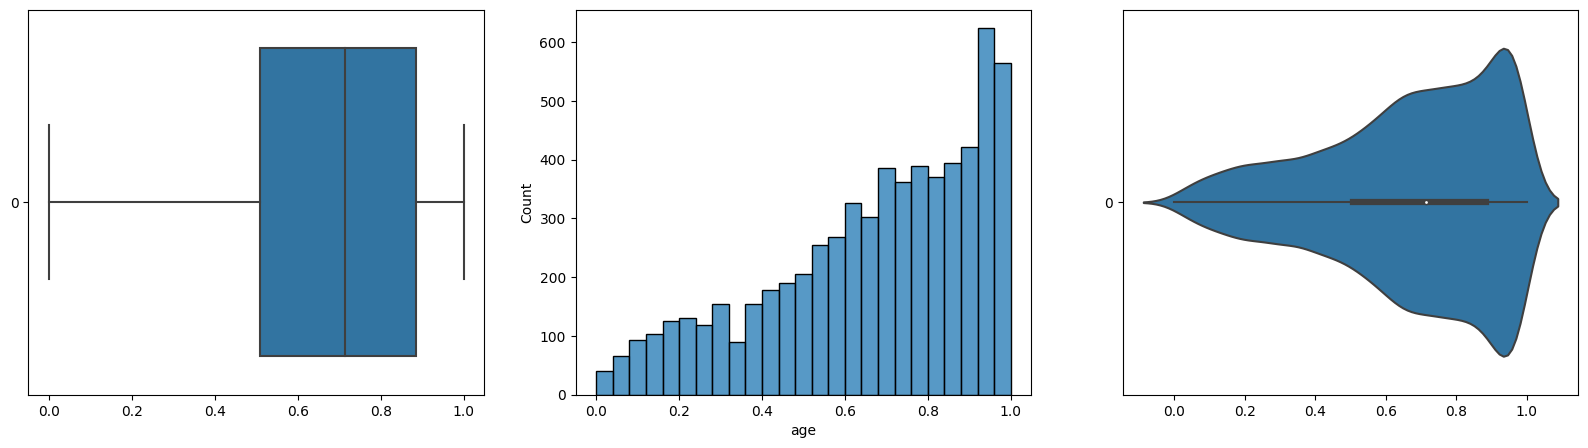

 avg_glucose_level  : 


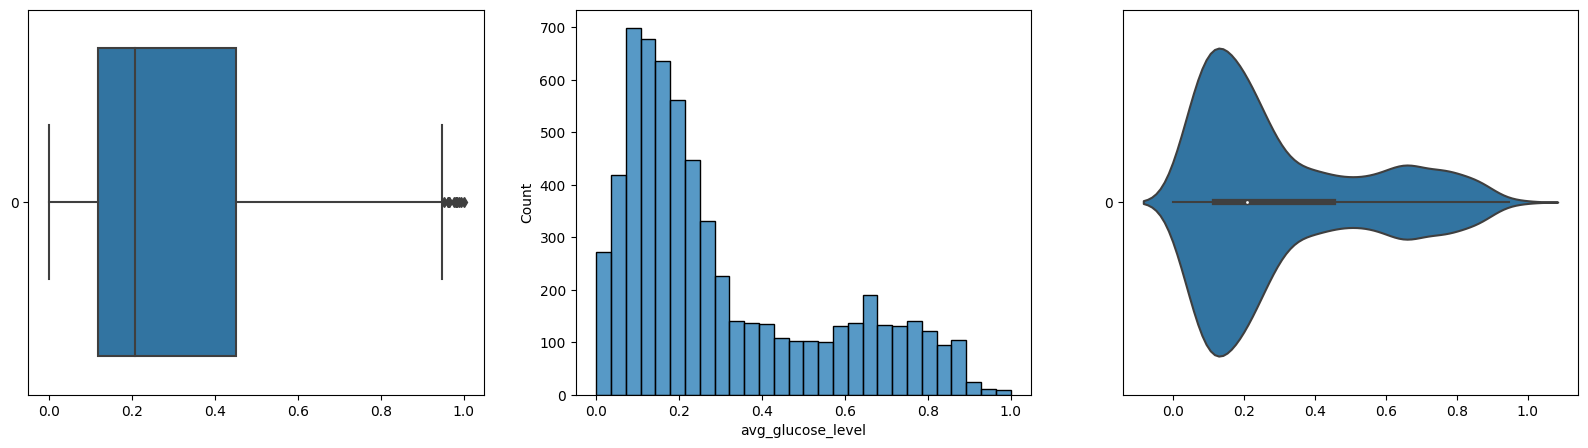

 bmi  : 


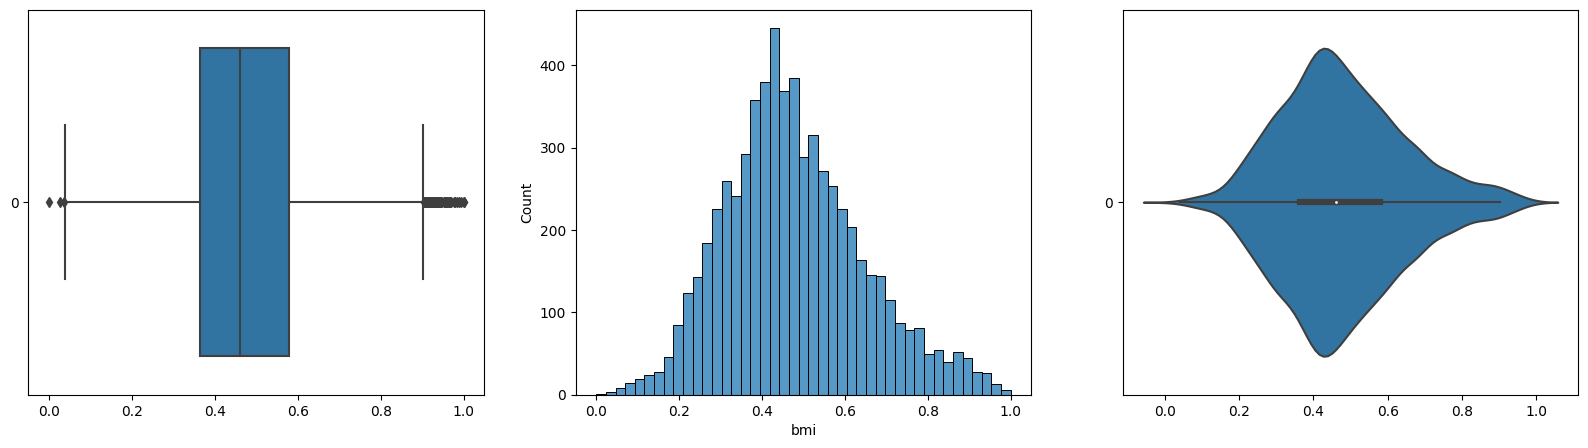

In [40]:
numerical = data[[ "age", "avg_glucose_level", "bmi"]];
plot_numerical(numerical);

 is_male  : 


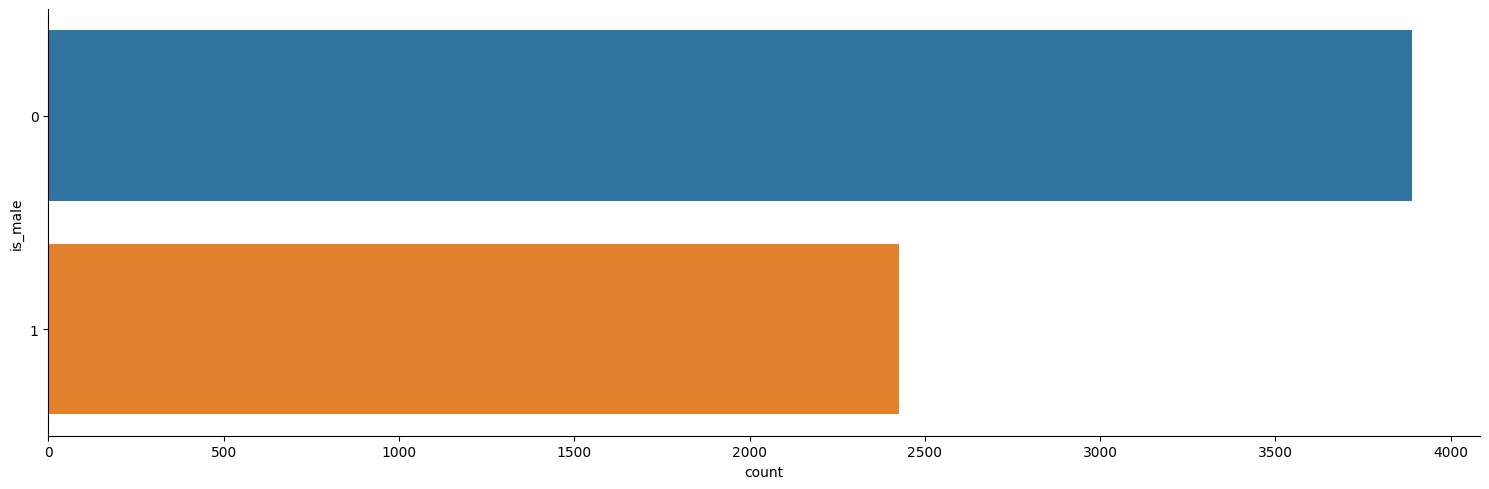

 hypertension  : 


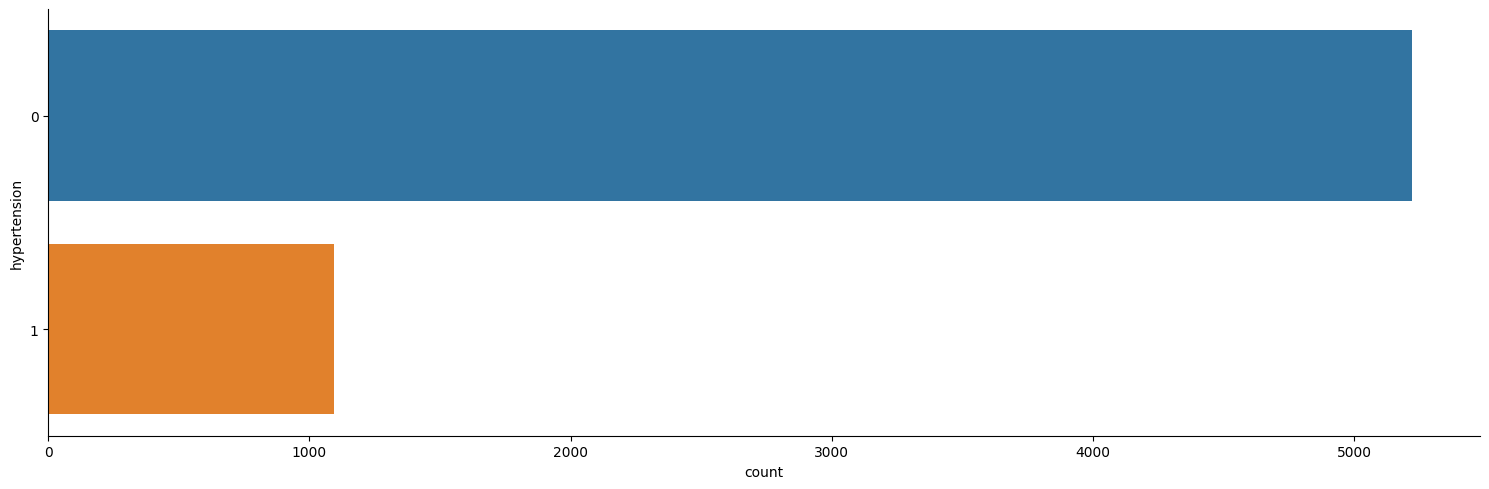

 heart_disease  : 


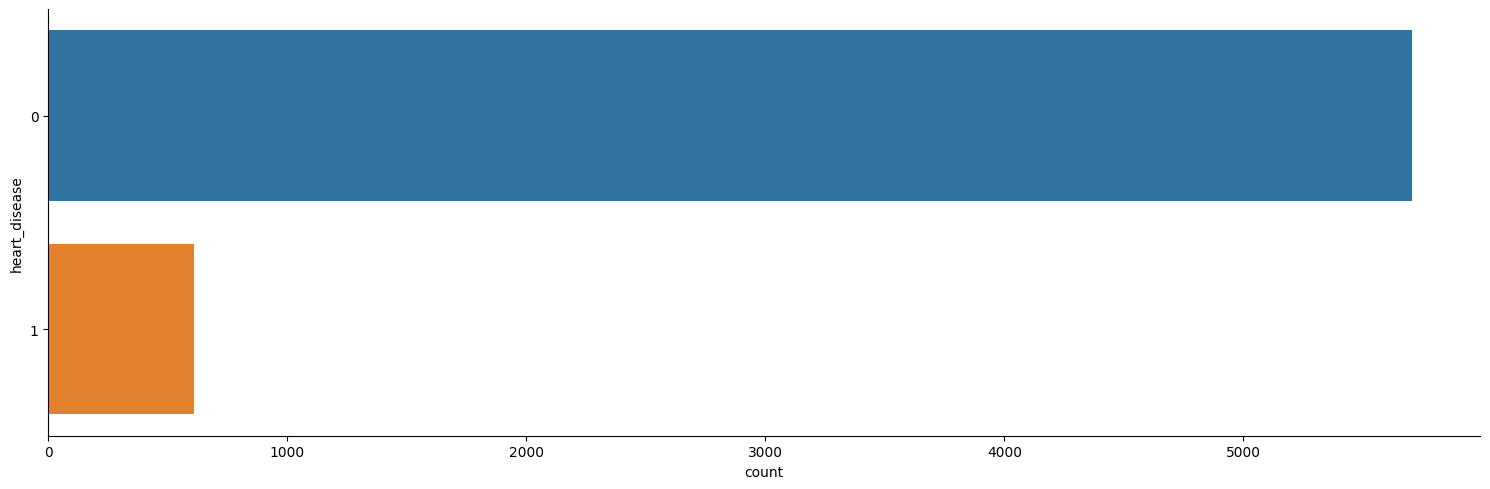

 work_type  : 


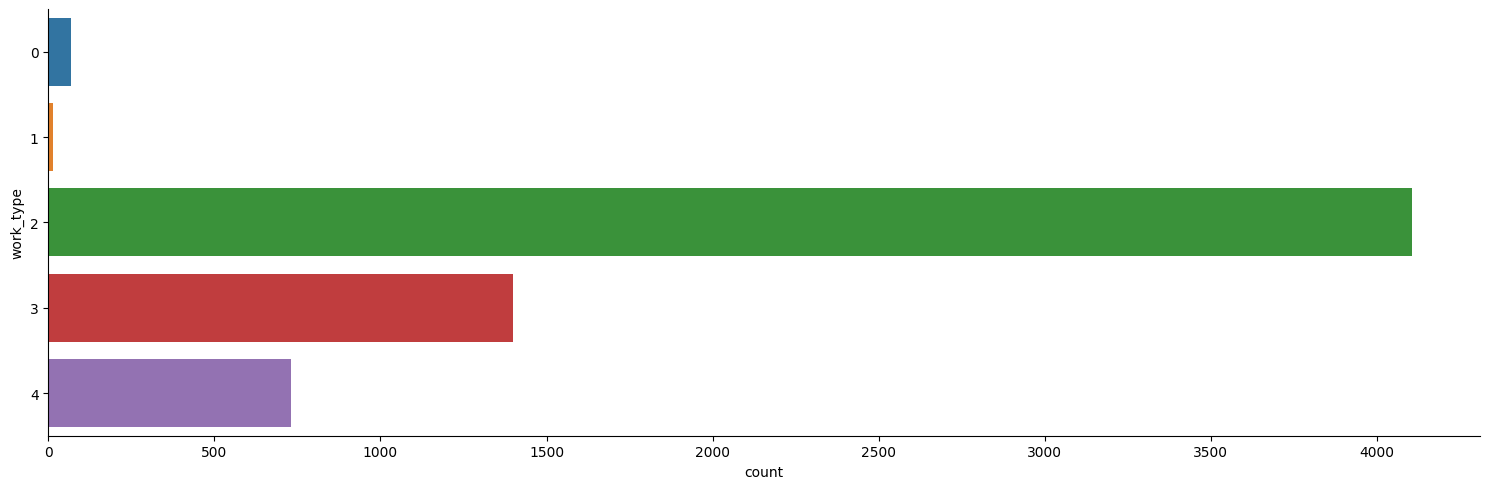

 ever_married  : 


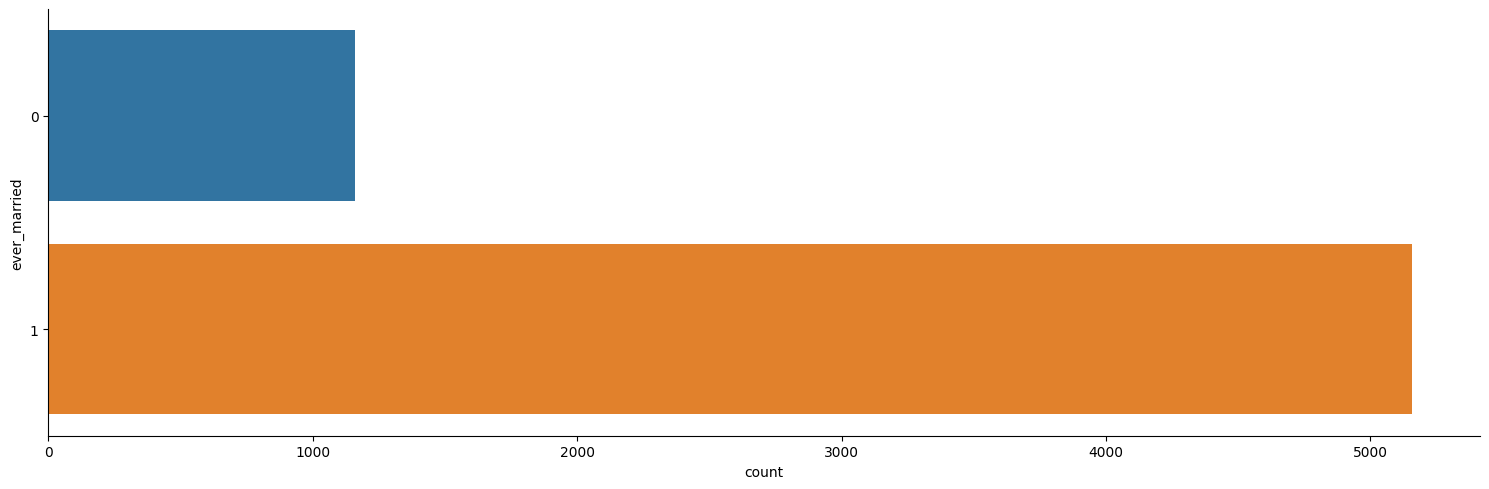

 is_urban  : 


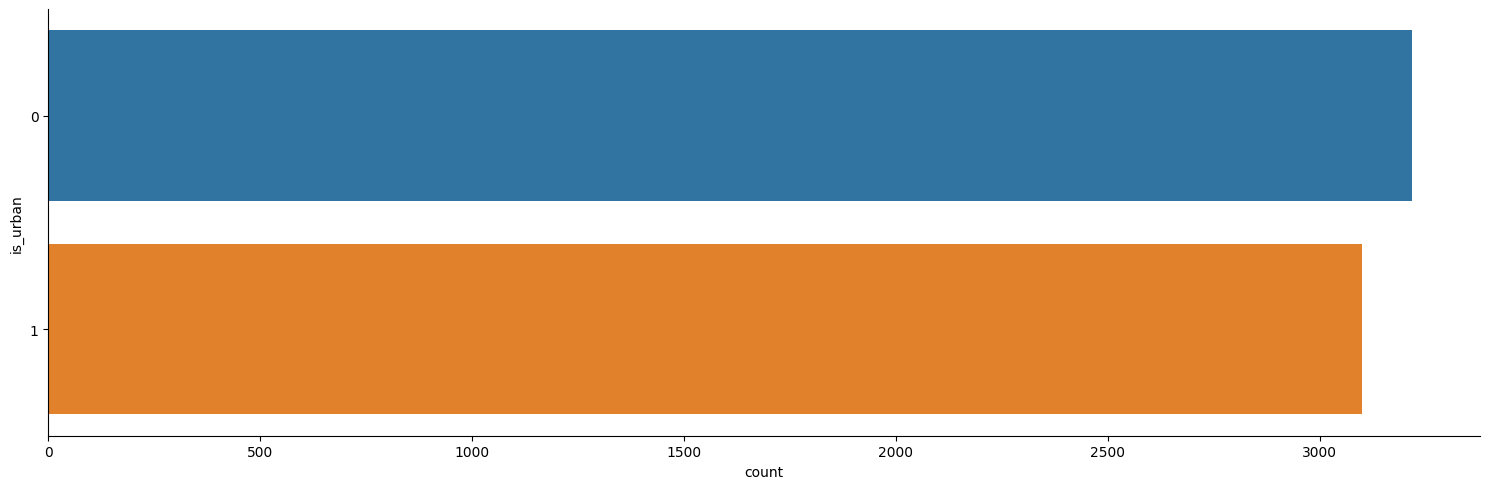

 smoking_status  : 


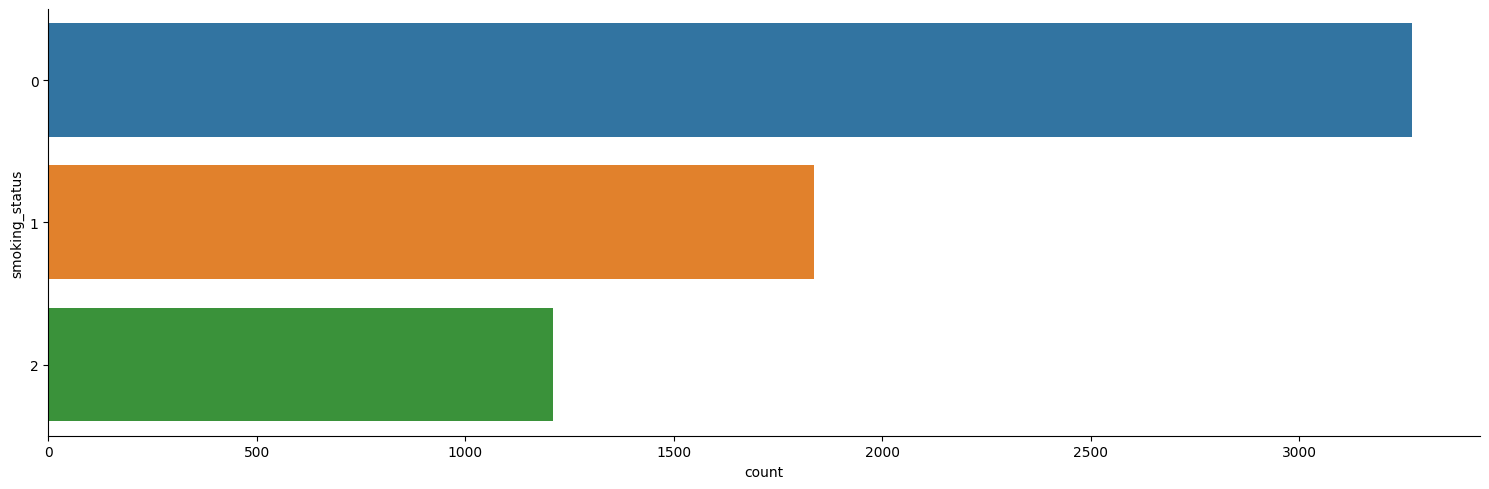

 stroke  : 


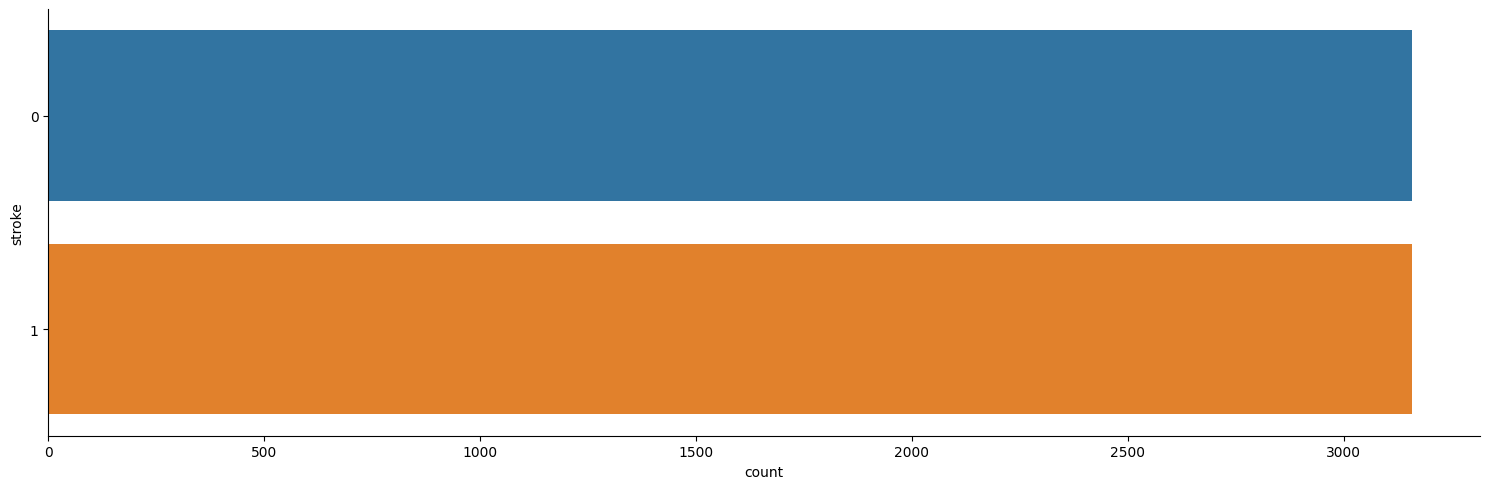

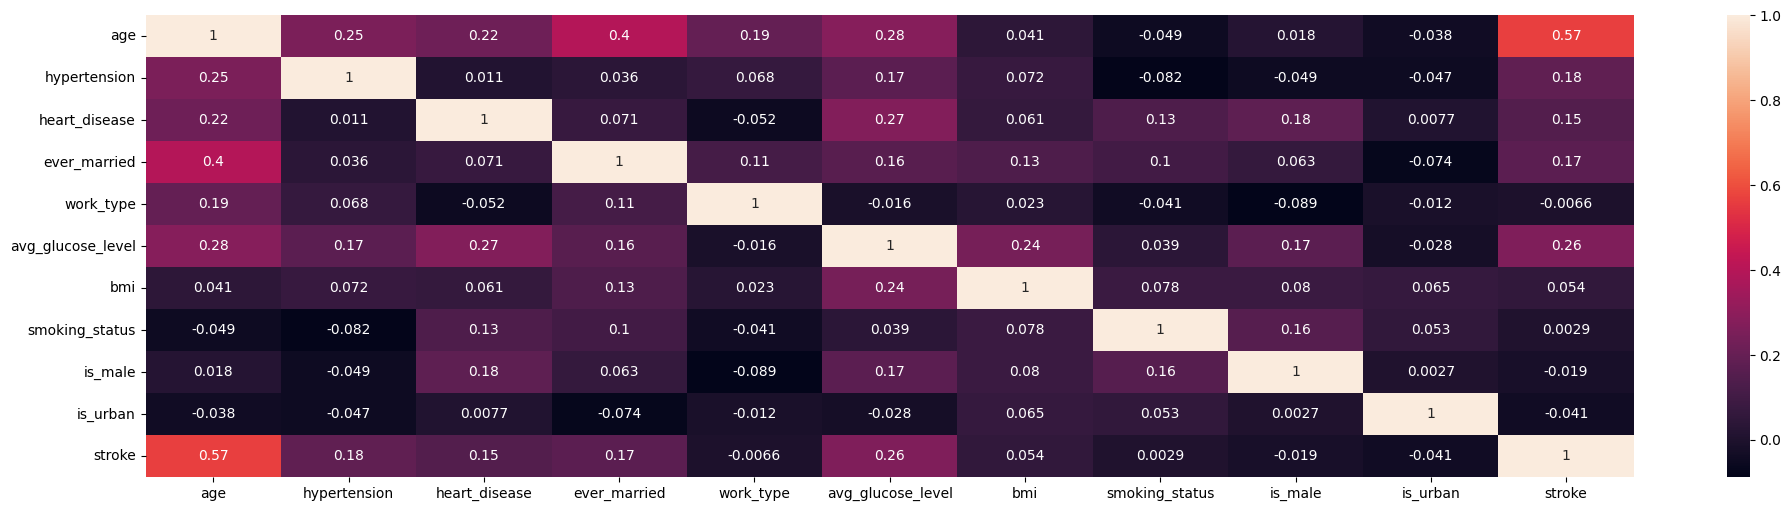

In [41]:
catergorical = data[["is_male","hypertension", "heart_disease", "work_type", "ever_married", "is_urban", "smoking_status", "stroke"]];
plot_categorical(catergorical);

sns.heatmap(data.corr(), annot = True);

<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;">Exploration of balanced dataset</h1>

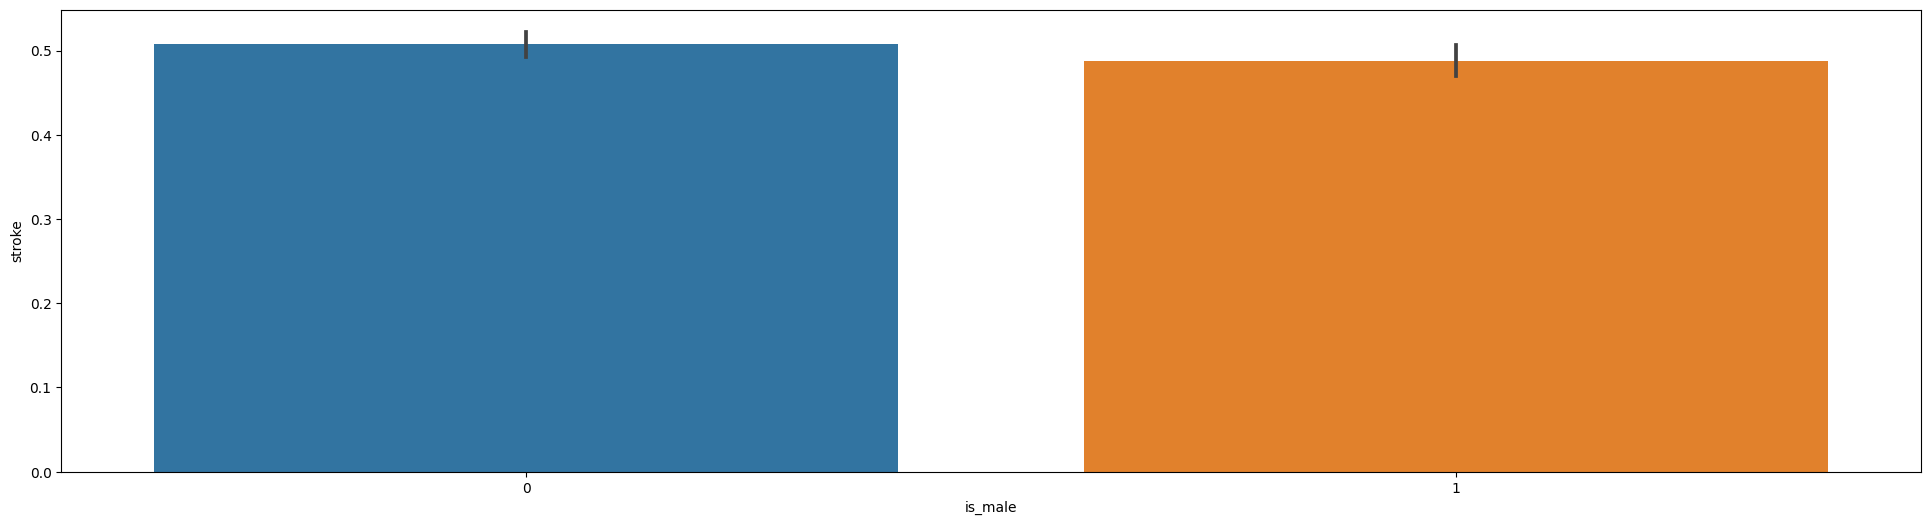

In [42]:
sns.barplot(data = data, x = "is_male", y = "stroke");

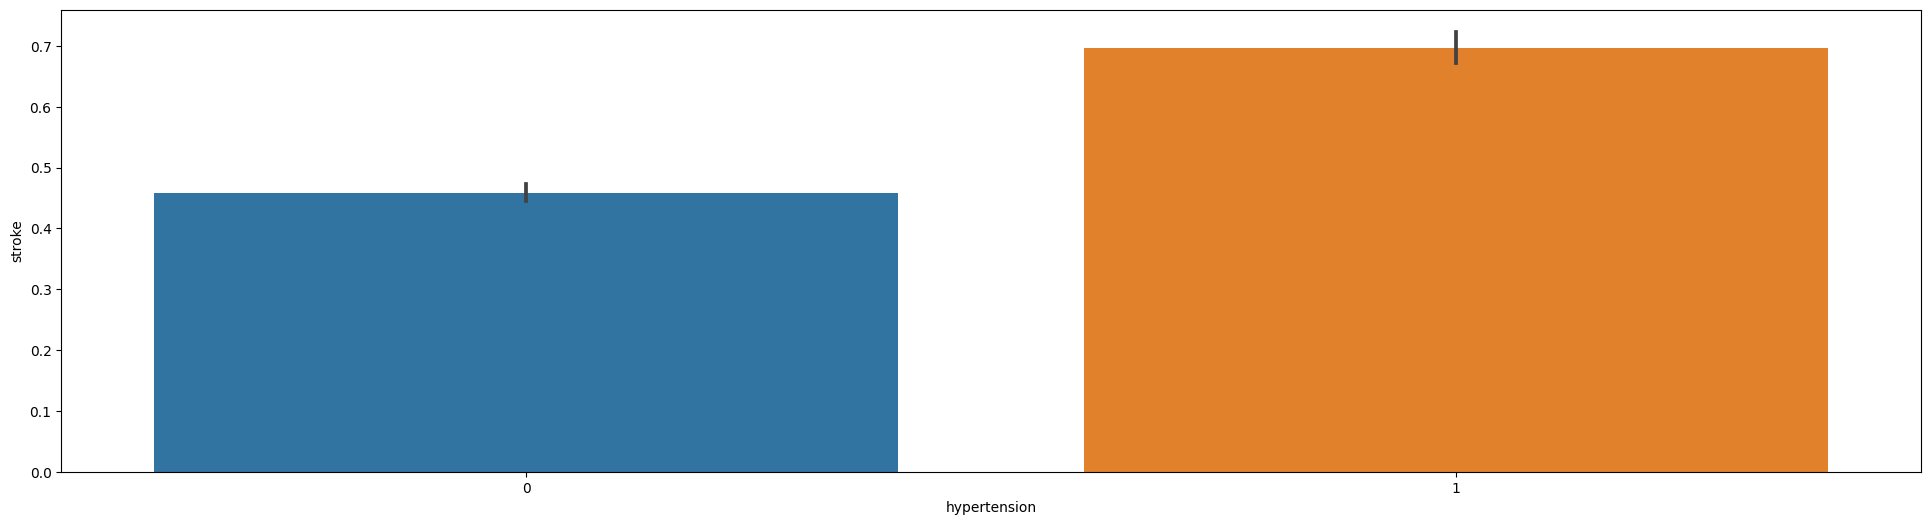

In [43]:
sns.barplot(data = data, x = "hypertension", y = "stroke");

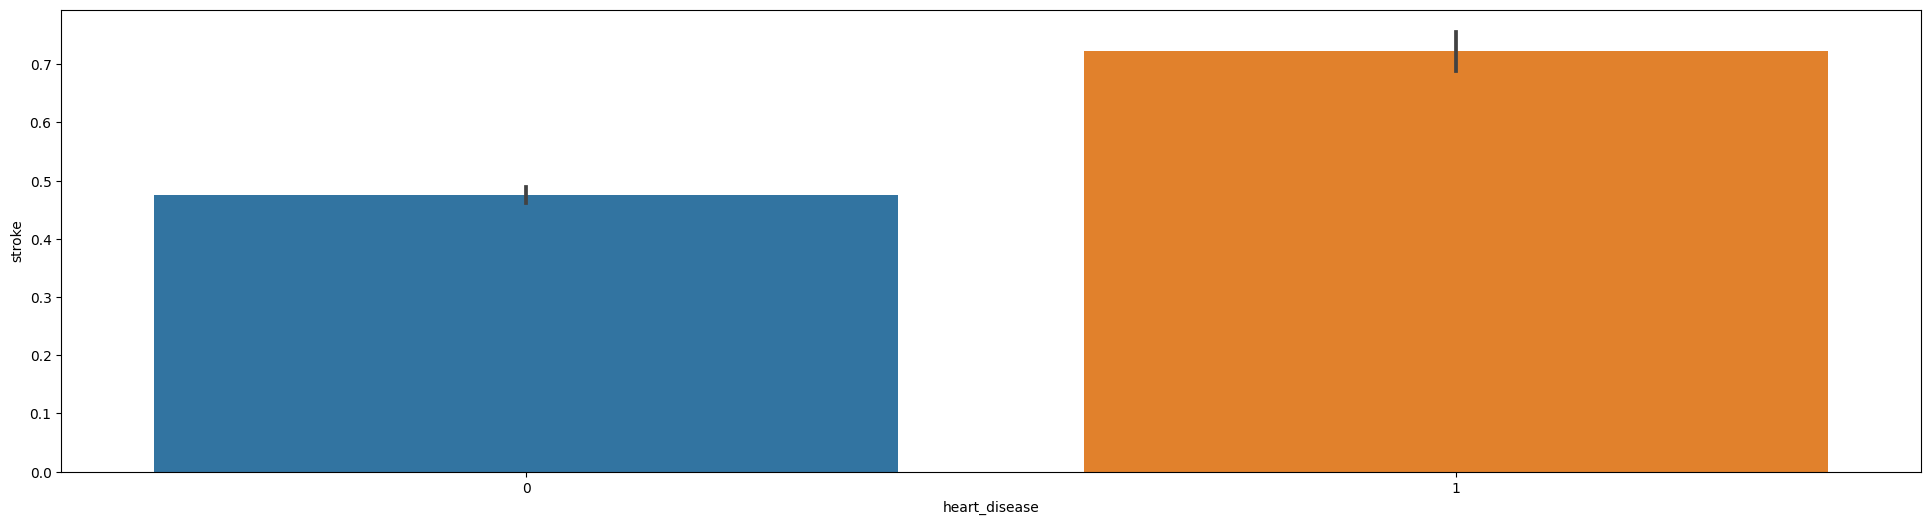

In [44]:
sns.barplot(data = data, x = "heart_disease", y = "stroke");

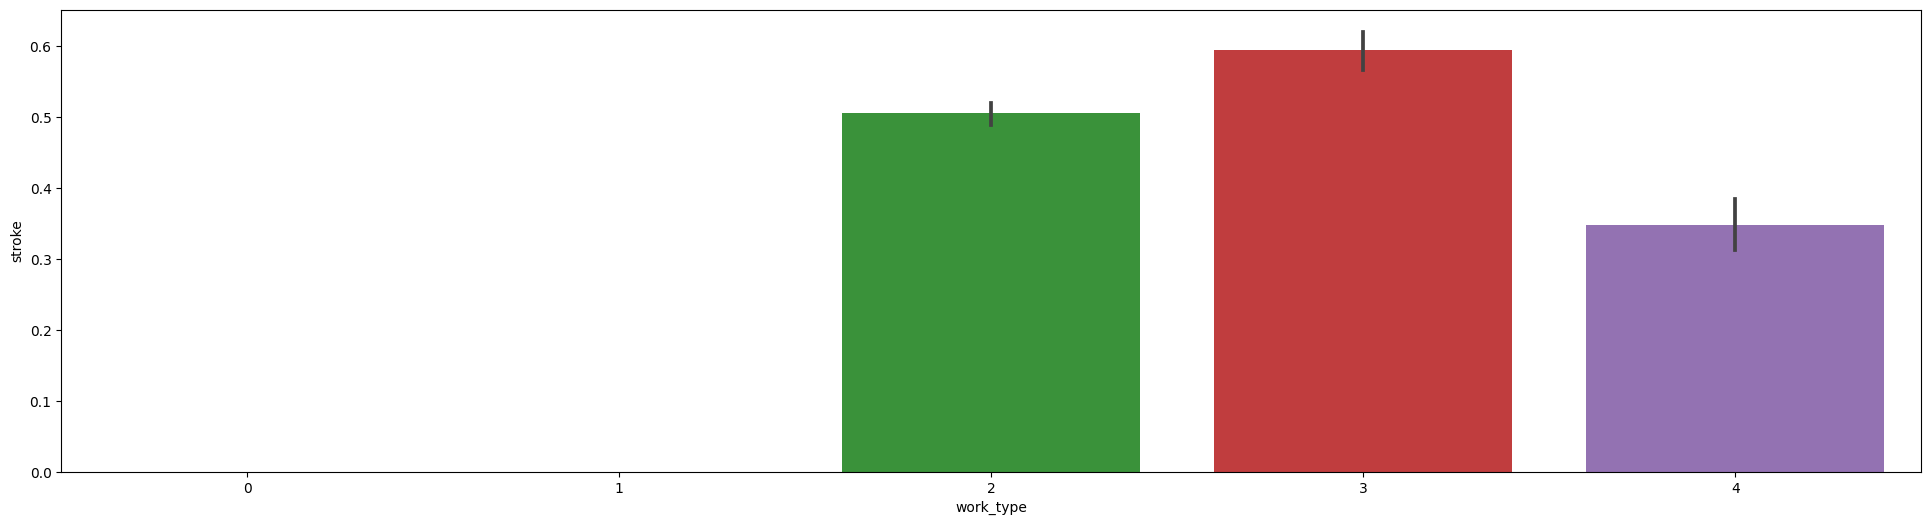

In [45]:
sns.barplot(data = data, x = "work_type", y = "stroke");

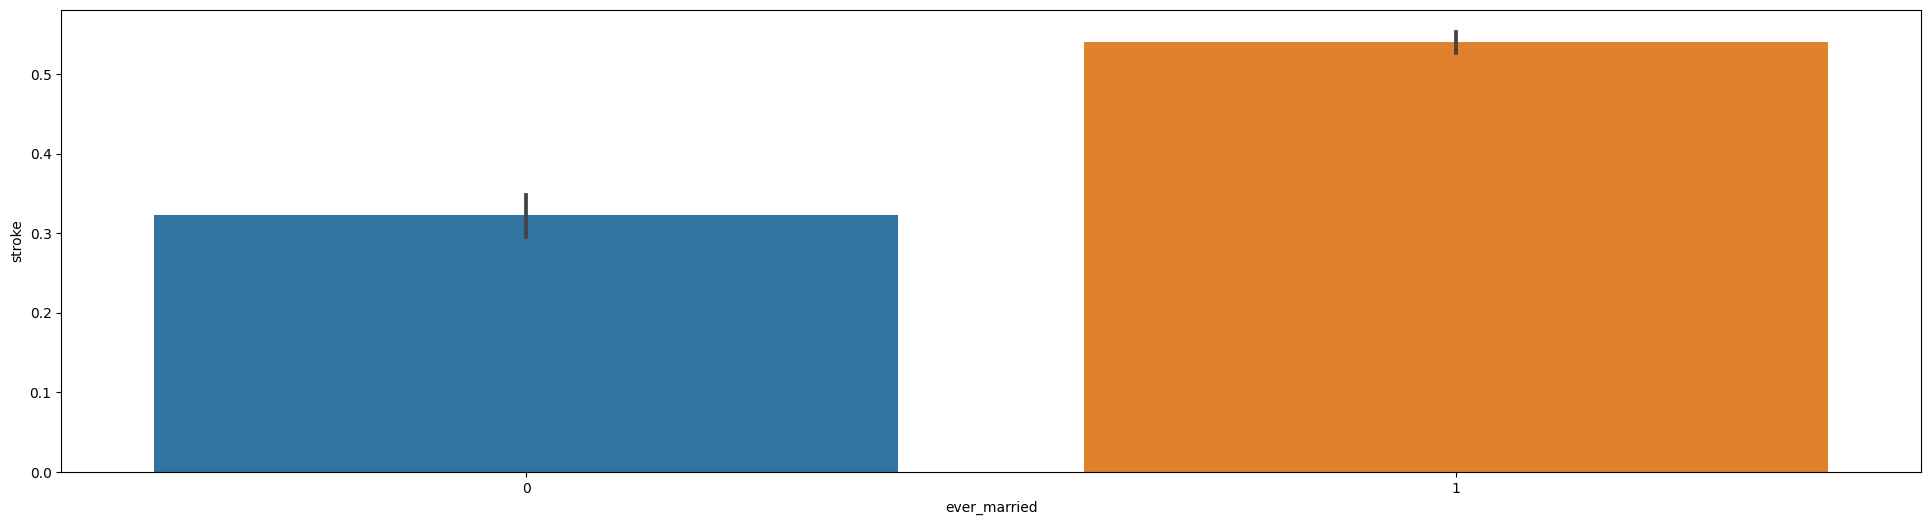

In [46]:
sns.barplot(data = data, x = "ever_married", y = "stroke");

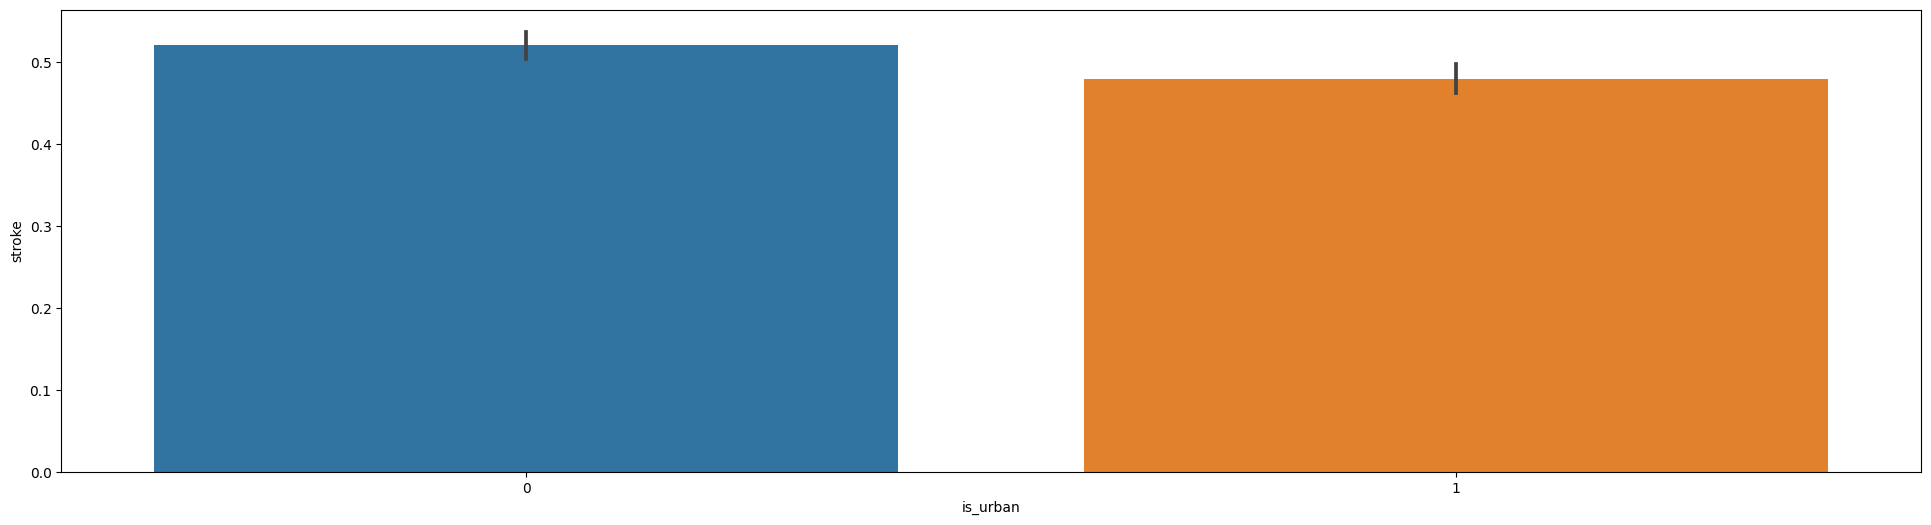

In [47]:
sns.barplot(data = data, x = "is_urban", y = "stroke");

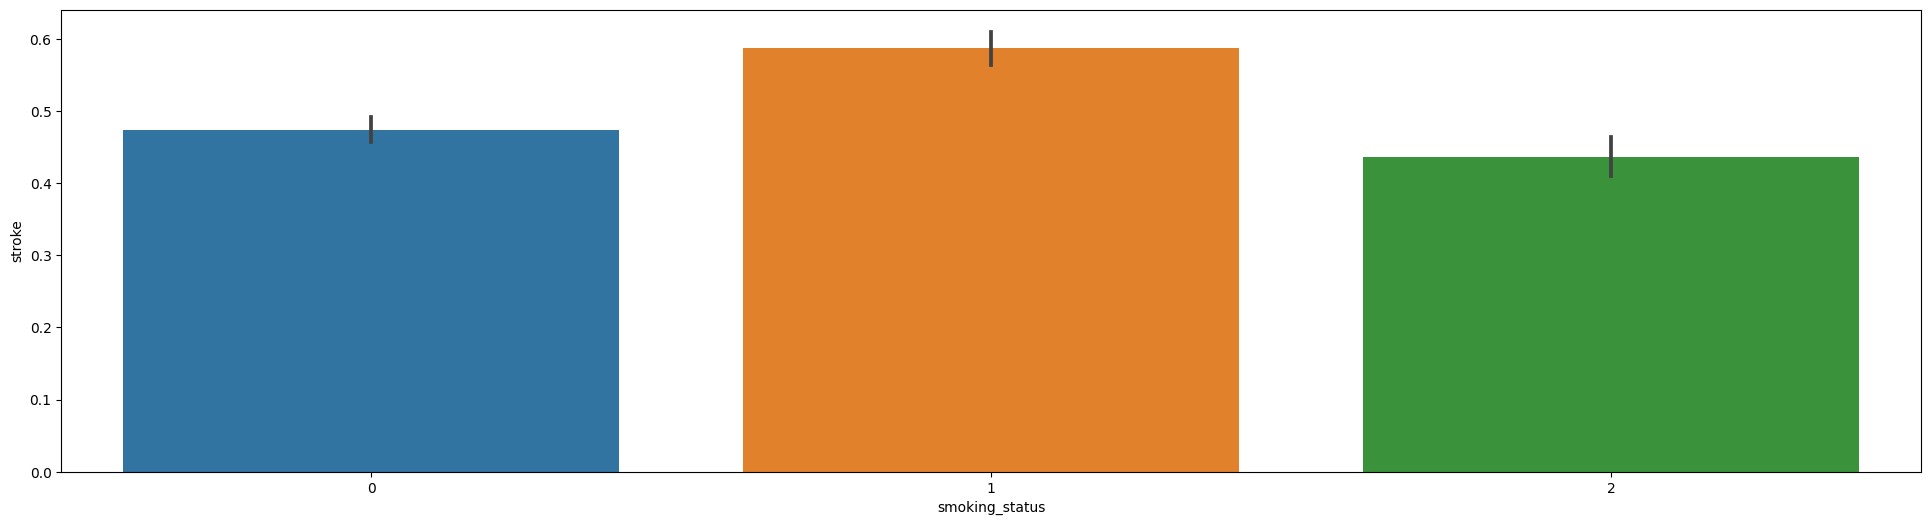

In [48]:
sns.barplot(data = data, x = "smoking_status", y = "stroke");

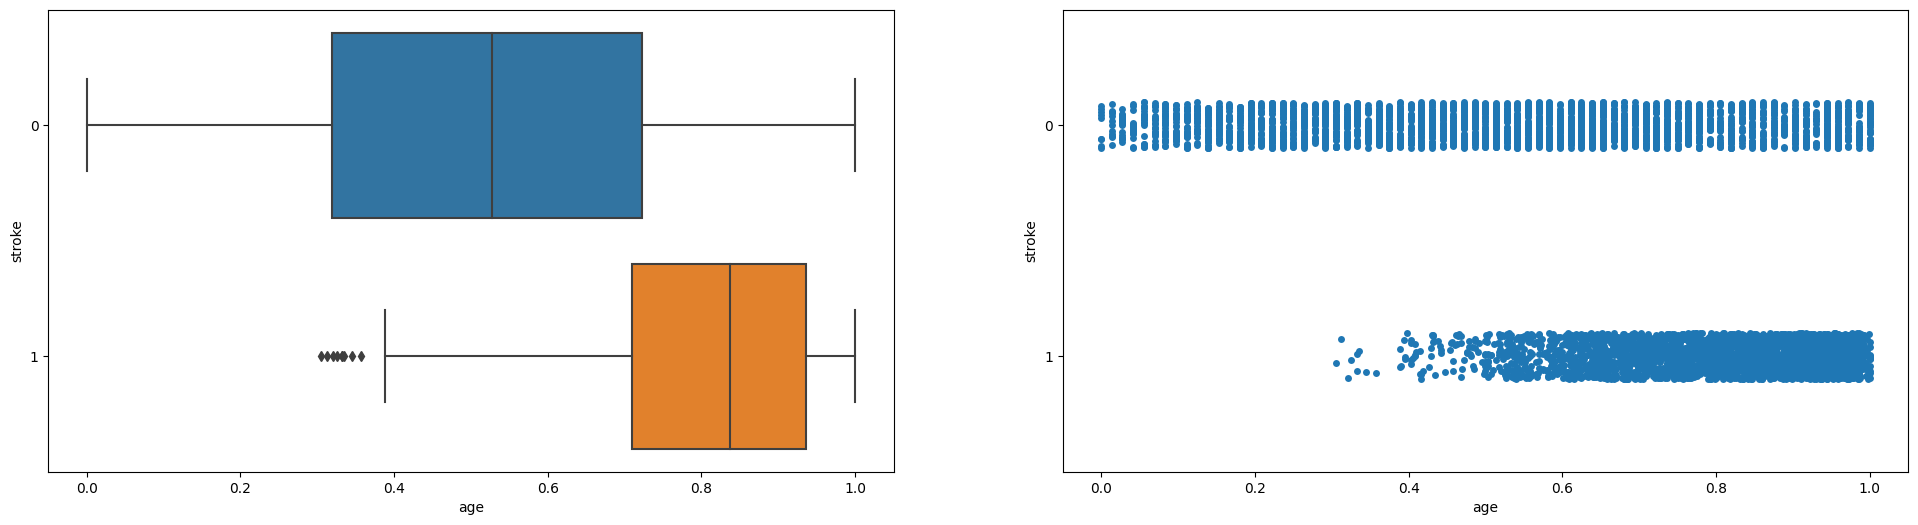

In [49]:
# Plottting age against stroke
f, axes = plt.subplots(1,2, figsize=(24,6));
sns.boxplot(data= data, x="age", y="stroke", orient="h", ax = axes[0]);
sns.stripplot(data= data, x="age", y="stroke", orient="h", ax= axes[1]);
plt.show();

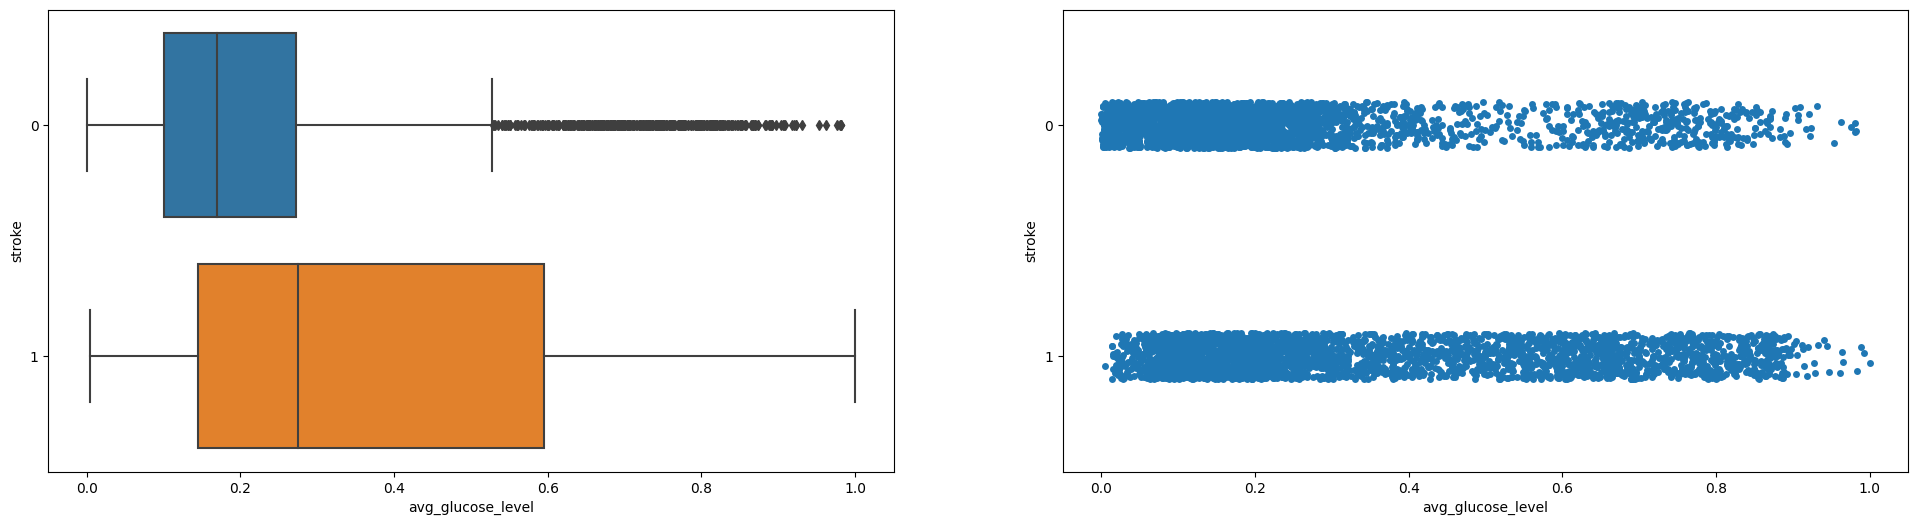

In [50]:
# Plotting avg_glucose_level against stroke
f, axes = plt.subplots(1,2, figsize=(24,6));
sns.boxplot(data = data, x="avg_glucose_level", y="stroke", orient="h", ax = axes[0]);
sns.stripplot(data = data, x="avg_glucose_level", y="stroke", orient="h", ax= axes[1]);
plt.show();

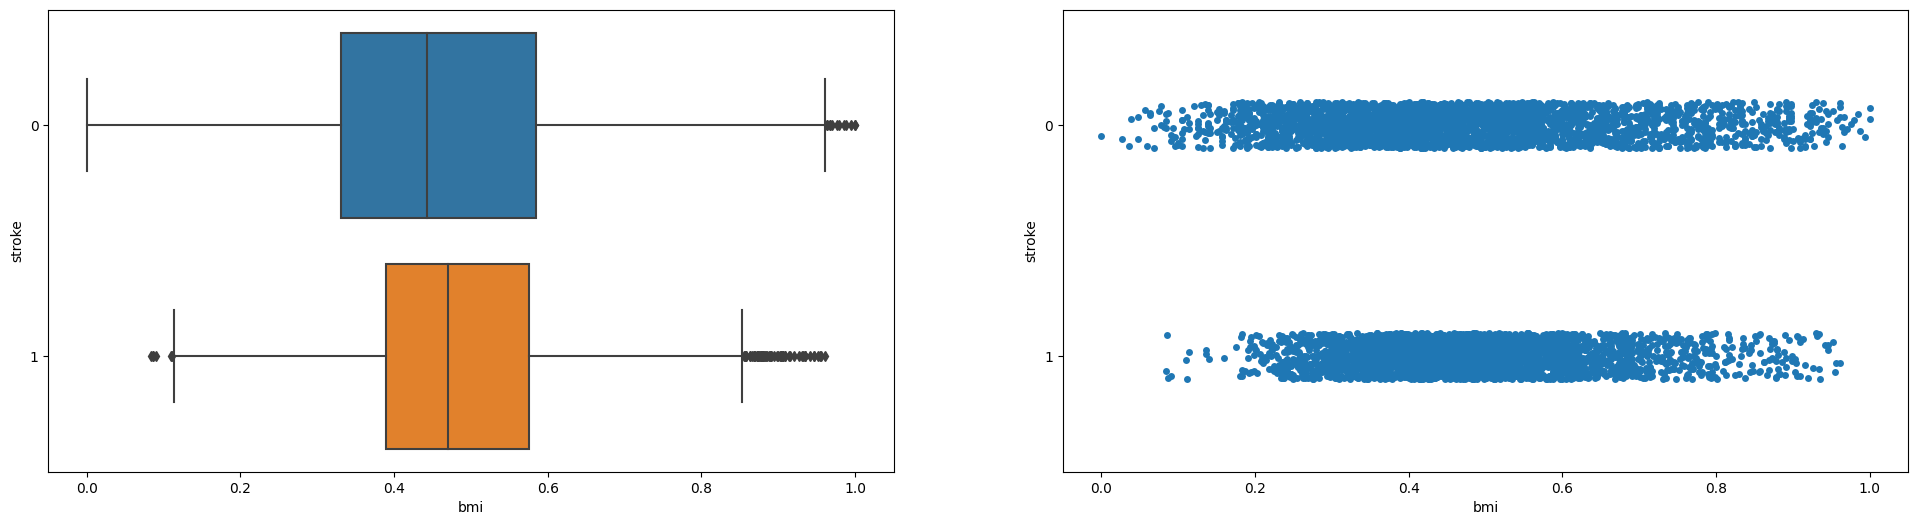

In [51]:
# Plotting bmi against stroke
f, axes = plt.subplots(1,2, figsize=(24,6));
sns.boxplot(data= data, x="bmi", y="stroke", orient="h", ax = axes[0]);
sns.stripplot(data= data, x="bmi", y="stroke", orient="h", ax= axes[1]);
plt.show();

<p style="color:lightgreen;">Taking a better look now we can see that <span style="color:red;"> correlation is not </span> a good way to see <span style="color:red;"> feature importance </span>

<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;">Training of new model</h1>

In [52]:
x_train, y_train, x_test, y_test = train_test_split(data.drop("stroke", axis = 1), data["stroke"], test_size = 0.2, random_state = 42);
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape);

(5052, 10) (1264, 10) (5052,) (1264,)


              precision    recall  f1-score   support

           0       0.80      0.73      0.76       633
           1       0.75      0.82      0.78       631

    accuracy                           0.77      1264
   macro avg       0.77      0.77      0.77      1264
weighted avg       0.77      0.77      0.77      1264



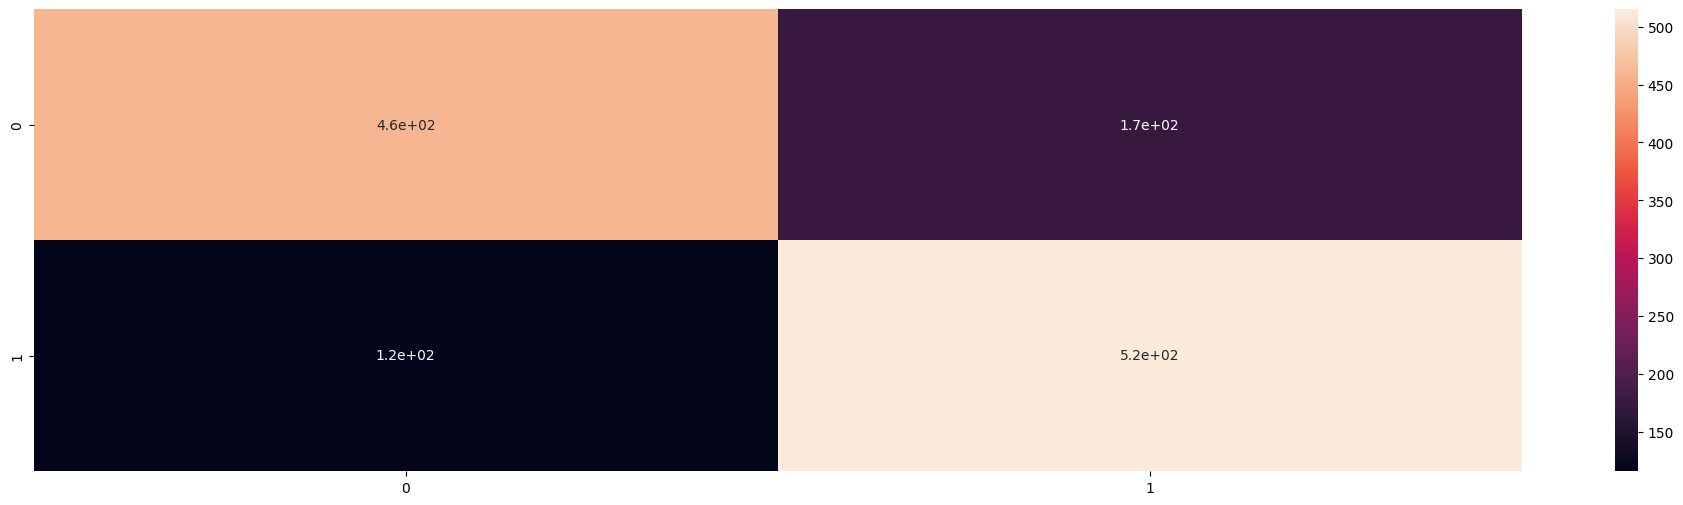

In [53]:
logreg = LogisticRegression();
logreg.fit(x_train, x_test);
prediction = logreg.predict(y_train);
confusion = confusion_matrix(y_test, prediction);

print(classification_report(y_test, prediction));
sns.heatmap(confusion, annot = True);

<p style="color:lightgreen;"> There we go. </p>

<h1 style="width:100%;background-color:white;color:black;text-align:center;font-weight:bold;">Training of model (Neural Network)</h1>

In [54]:
epochs = 27;

model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation = "relu"),
    tf.keras.layers.Dense(18, activation = "relu"),
    tf.keras.layers.Dense(9, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
]);

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name = "Accuracy"),
        tf.keras.metrics.Precision(name = "Precision"),
        tf.keras.metrics.Recall(name = "Recall"),
    ]
);


# Training the model
trained_model = model.fit(x_train, x_test, epochs = epochs);

Epoch 1/27
158/158 [==============================] - 2s 3ms/step - loss: 0.6769 - Accuracy: 0.5825 - Precision: 0.5908 - Recall: 0.5382
Epoch 2/27
158/158 [==============================] - 1s 3ms/step - loss: 0.6050 - Accuracy: 0.6894 - Precision: 0.6659 - Recall: 0.7610
Epoch 3/27
158/158 [==============================] - 1s 3ms/step - loss: 0.5466 - Accuracy: 0.7361 - Precision: 0.7040 - Recall: 0.8152
Epoch 4/27
158/158 [==============================] - 0s 3ms/step - loss: 0.5012 - Accuracy: 0.7583 - Precision: 0.7266 - Recall: 0.8287
Epoch 5/27
158/158 [==============================] - 1s 3ms/step - loss: 0.4757 - Accuracy: 0.7767 - Precision: 0.7423 - Recall: 0.8480
Epoch 6/27
158/158 [==============================] - 0s 3ms/step - loss: 0.4658 - Accuracy: 0.7852 - Precision: 0.7514 - Recall: 0.8528
Epoch 7/27
158/158 [==============================] - 0s 3ms/step - loss: 0.4610 - Accuracy: 0.7848 - Precision: 0.7491 - Recall: 0.8567
Epoch 8/27
158/158 [=====================

<p style="color:lightgreen;"> Lets plot the model's training data to see how it performed. </p>

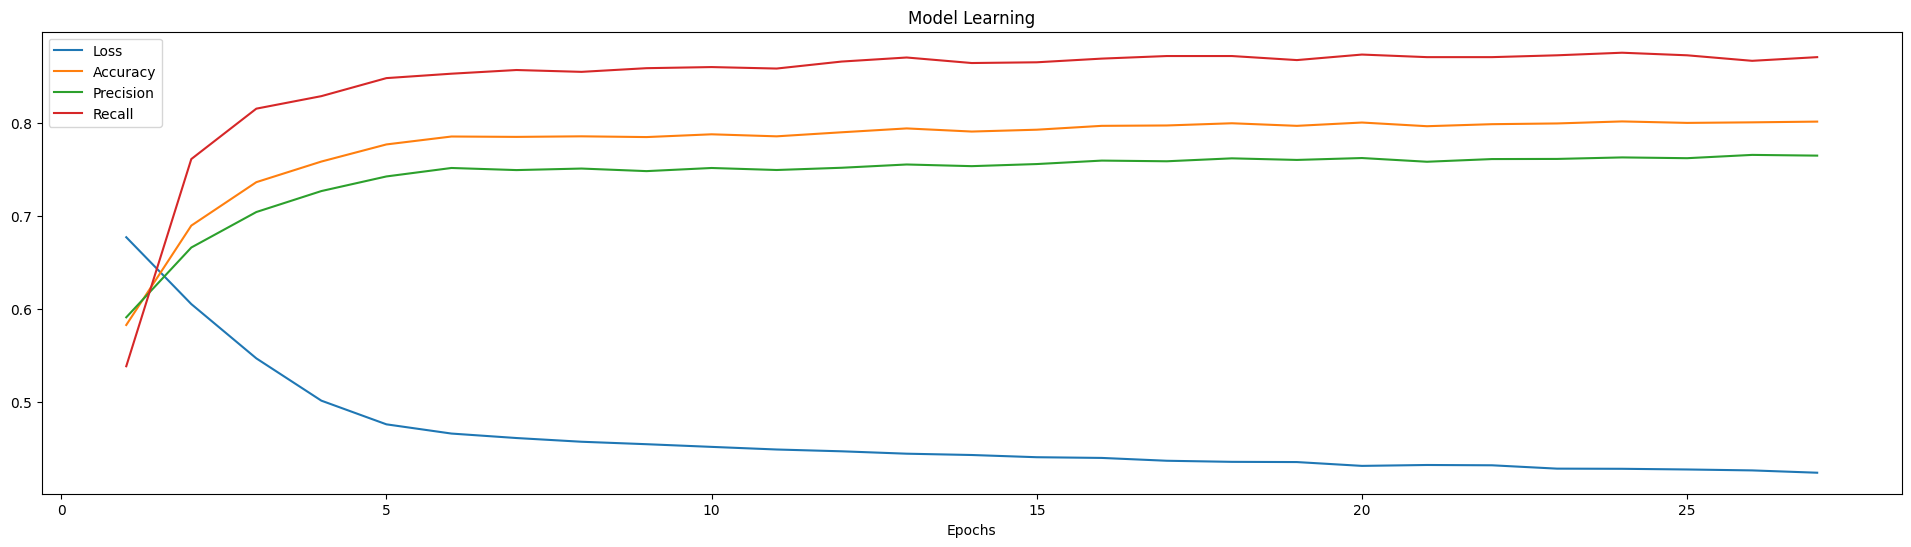

In [55]:
# Visualizing model learning
plt.plot(np.arange(1,epochs + 1), trained_model.history["loss"], label = "Loss");
plt.plot(np.arange(1,epochs + 1), trained_model.history["Accuracy"], label = "Accuracy");
plt.plot(np.arange(1,epochs + 1), trained_model.history["Precision"], label = "Precision");
plt.plot(np.arange(1,epochs + 1), trained_model.history["Recall"], label = "Recall");
plt.title("Model Learning");
plt.xlabel("Epochs");
plt.legend();

<p style="color:lightgreen;"> Looking at the model's performance it seems like it might be over-fitting the train data. Lets reduce the number of epochs. </p>

In [56]:
#Reduced number of epochs to 15
epochs = 15;

model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation = "relu"),
    tf.keras.layers.Dense(18, activation = "relu"),
    tf.keras.layers.Dense(9, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
]);

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name = "Accuracy"),
        tf.keras.metrics.Precision(name = "Precision"),
        tf.keras.metrics.Recall(name = "Recall"),
    ]
);

trained_model = model.fit(x_train, x_test, epochs = epochs);

Epoch 1/15
158/158 [==============================] - 2s 3ms/step - loss: 0.6714 - Accuracy: 0.6079 - Precision: 0.5946 - Recall: 0.6791
Epoch 2/15
158/158 [==============================] - 1s 3ms/step - loss: 0.5815 - Accuracy: 0.7223 - Precision: 0.6997 - Recall: 0.7792
Epoch 3/15
158/158 [==============================] - 1s 3ms/step - loss: 0.5166 - Accuracy: 0.7563 - Precision: 0.7309 - Recall: 0.8116
Epoch 4/15
158/158 [==============================] - 0s 3ms/step - loss: 0.4885 - Accuracy: 0.7745 - Precision: 0.7416 - Recall: 0.8429
Epoch 5/15
158/158 [==============================] - 1s 3ms/step - loss: 0.4726 - Accuracy: 0.7743 - Precision: 0.7409 - Recall: 0.8441
Epoch 6/15
158/158 [==============================] - 1s 3ms/step - loss: 0.4620 - Accuracy: 0.7848 - Precision: 0.7486 - Recall: 0.8579
Epoch 7/15
158/158 [==============================] - 1s 3ms/step - loss: 0.4551 - Accuracy: 0.7882 - Precision: 0.7516 - Recall: 0.8611
Epoch 8/15
158/158 [=====================

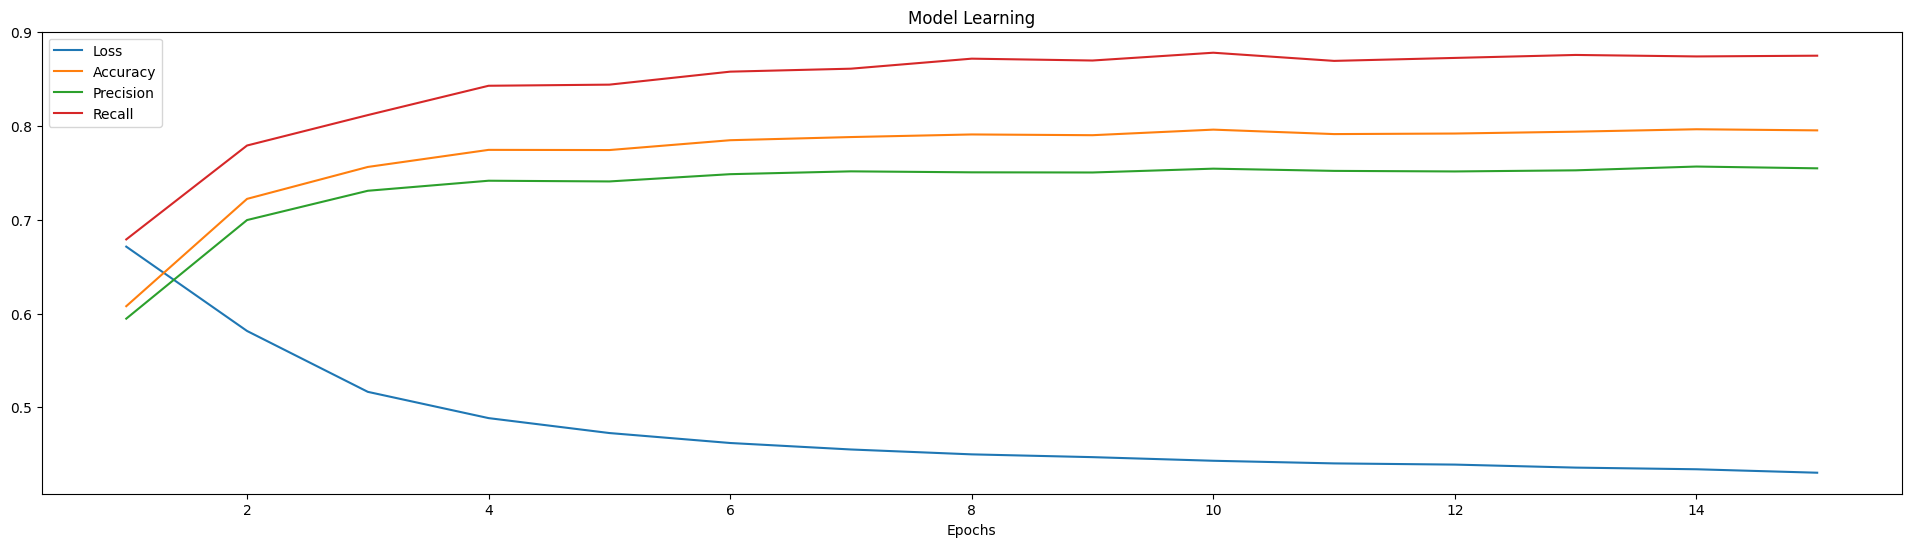

In [57]:
# Visualizing model learning
plt.plot(np.arange(1,epochs + 1), trained_model.history["loss"], label = "Loss");
plt.plot(np.arange(1,epochs + 1), trained_model.history["Accuracy"], label = "Accuracy");
plt.plot(np.arange(1,epochs + 1), trained_model.history["Precision"], label = "Precision");
plt.plot(np.arange(1,epochs + 1), trained_model.history["Recall"], label = "Recall");
plt.title("Model Learning");
plt.xlabel("Epochs");
plt.legend();

<p style="color:lightgreen;">Testing the neural network model. </p>

In [58]:
results = model.evaluate(y_train, y_test, batch_size=128);

predictions = model.predict(y_train)
predictions = np.where(predictions > 0.5, 1, 0);
display(predictions);
display(y_test);

40/40 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

4080    1
3841    1
712     0
3646    1
3133    0
       ..
1433    0
292     0
1142    0
4308    1
5009    1
Name: stroke, Length: 1264, dtype: int64

<p style="color:lightgreen;"> Comparing the two models, we can see that <span style="color:red;">Logistic Regression </span> produces a better predicition accuracy compared to the <span style="color:red;"> Neural Network </span> model. </p>